# Proyecto Final - Módulo No Supervisado
**Maestría en Ciencias de Información y las Comunicaciones - Big Data**

---

**Autores**: Álvaro Alejandro Zarabanda Gutiérrez - Youssef Alejandro Ortiz  
**Códigos**: 20251595006 - 20251595XXX   
**Fecha**: Octubre 2025

## Importación de Librerías

Importamos todas las librerías necesarias para el análisis de clustering y evaluación semi-supervisada.

In [ ]:
# ================================
# IMPORTACIÓN DE LIBRERÍAS
# ================================

# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy.io import loadmat, savemat
from itertools import product

# Librerías adicionales para visualizaciones avanzadas
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Librerías de machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
warnings.filterwarnings('ignore')

# Configuración para plotly
pyo.init_notebook_mode(connected=True)

# Seed para reproducibilidad
np.random.seed(42)

# Configuración de impresión
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

Todas las librerías importadas exitosamente
Configuración de visualización establecida
Seed de reproducibilidad configurado (42)


## Parte 1: Carga y Análisis Exploratorio del Dataset

**Objetivo**: Cargar y caracterizar el dataset `dato_taller.mat` para entender el problema de clasificación.

In [2]:
# ================================
# CARGA Y EXPLORACIÓN DEL DATASET
# ================================

print("Cargando dataset dato_taller.mat...")

# Cargar el archivo .mat
try:
    mat_data = loadmat('dato_taller.mat')
    
    # Mostrar todas las claves disponibles
    print("\nClaves disponibles en el archivo .mat:")
    data_keys = []
    for key in mat_data.keys():
        if not key.startswith('__'):
            print(f"   {key}: {mat_data[key].shape} ({mat_data[key].dtype})")
            data_keys.append(key)
    
    print(f"\nSe encontraron {len(data_keys)} matrices de datos principales")
    
    # Análisis detallado de cada matriz
    for key in data_keys:
        data = mat_data[key]
        print(f"\nAnálisis de '{key}':")
        print(f"   Dimensiones: {data.shape}")
        print(f"   Tipo de datos: {data.dtype}")
        print(f"   Rango de valores: [{data.min():.4f}, {data.max():.4f}]")
        print(f"   Estadísticas: μ={data.mean():.4f}, σ={data.std():.4f}")
        
        # Si es un vector (posibles etiquetas)
        if len(data.shape) == 2 and min(data.shape) == 1:
            unique_vals = np.unique(data.flatten())
            print(f"   Valores únicos: {unique_vals}")
            print(f"   Distribución: {[(val, np.sum(data.flatten() == val)) for val in unique_vals]}")
    
except Exception as e:
    print(f"Error cargando el dataset: {e}")
    
print(f"\nDataset cargado exitosamente desde: {Path('dato_taller.mat').absolute()}")

Cargando dataset dato_taller.mat...

Claves disponibles en el archivo .mat:
   x_prueba: (10000, 20) (float64)
   x_entena: (1000, 20) (float64)
   y_entrena: (1000, 1) (int16)

Se encontraron 3 matrices de datos principales

Análisis de 'x_prueba':
   Dimensiones: (10000, 20)
   Tipo de datos: float64
   Rango de valores: [-4.7194, 4.7795]
   Estadísticas: μ=0.0028, σ=1.0958

Análisis de 'x_entena':
   Dimensiones: (1000, 20)
   Tipo de datos: float64
   Rango de valores: [-4.0843, 4.4016]
   Estadísticas: μ=0.0117, σ=1.0977

Análisis de 'y_entrena':
   Dimensiones: (1000, 1)
   Tipo de datos: int16
   Rango de valores: [-1.0000, 1.0000]
   Estadísticas: μ=0.0620, σ=0.9981
   Valores únicos: [-1  1]
   Distribución: [(np.int16(-1), np.int64(469)), (np.int16(1), np.int64(531))]

Dataset cargado exitosamente desde: /home/aalejoz25/HDD/Alvaro/Universidad/Posgrado 1/Repositorios/Big_Data/aprendizaje_no_supervisado/trabajo_final/dato_taller.mat


In [3]:
# ================================
# PREPARACIÓN DE DATOS
# ================================

# Extraer matrices de datos
X_train = mat_data['x_entena']  # Datos de entrenamiento
y_train = mat_data['y_entrena'].flatten()  # Etiquetas de entrenamiento 
X_test = mat_data['x_prueba']   # Datos de prueba

print(f"Información de los datos extraídos:")
print(f"X_train: {X_train.shape} - Datos de entrenamiento")
print(f"y_train: {y_train.shape} - Etiquetas de entrenamiento") 
print(f"X_test: {X_test.shape} - Datos de prueba")

# Análisis de distribución de clases
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"\nDistribución de clases en entrenamiento:")
for clase, count in zip(unique_classes, class_counts):
    print(f"  Clase {clase}: {count} muestras ({count/len(y_train)*100:.1f}%)")

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDatos normalizados exitosamente")
print(f"X_train_scaled: μ={X_train_scaled.mean():.6f}, σ={X_train_scaled.std():.6f}")
print(f"X_test_scaled: μ={X_test_scaled.mean():.6f}, σ={X_test_scaled.std():.6f}")

Información de los datos extraídos:
X_train: (1000, 20) - Datos de entrenamiento
y_train: (1000,) - Etiquetas de entrenamiento
X_test: (10000, 20) - Datos de prueba

Distribución de clases en entrenamiento:
  Clase -1: 469 muestras (46.9%)
  Clase 1: 531 muestras (53.1%)

Datos normalizados exitosamente
X_train_scaled: μ=-0.000000, σ=1.000000
X_test_scaled: μ=-0.008134, σ=1.000050


## Parte 2.1: Visualizaciones del Análisis Exploratorio de Datos (EDA)

**Objetivo**: Visualizar la estructura y distribución de los datos para entender mejor el problema.

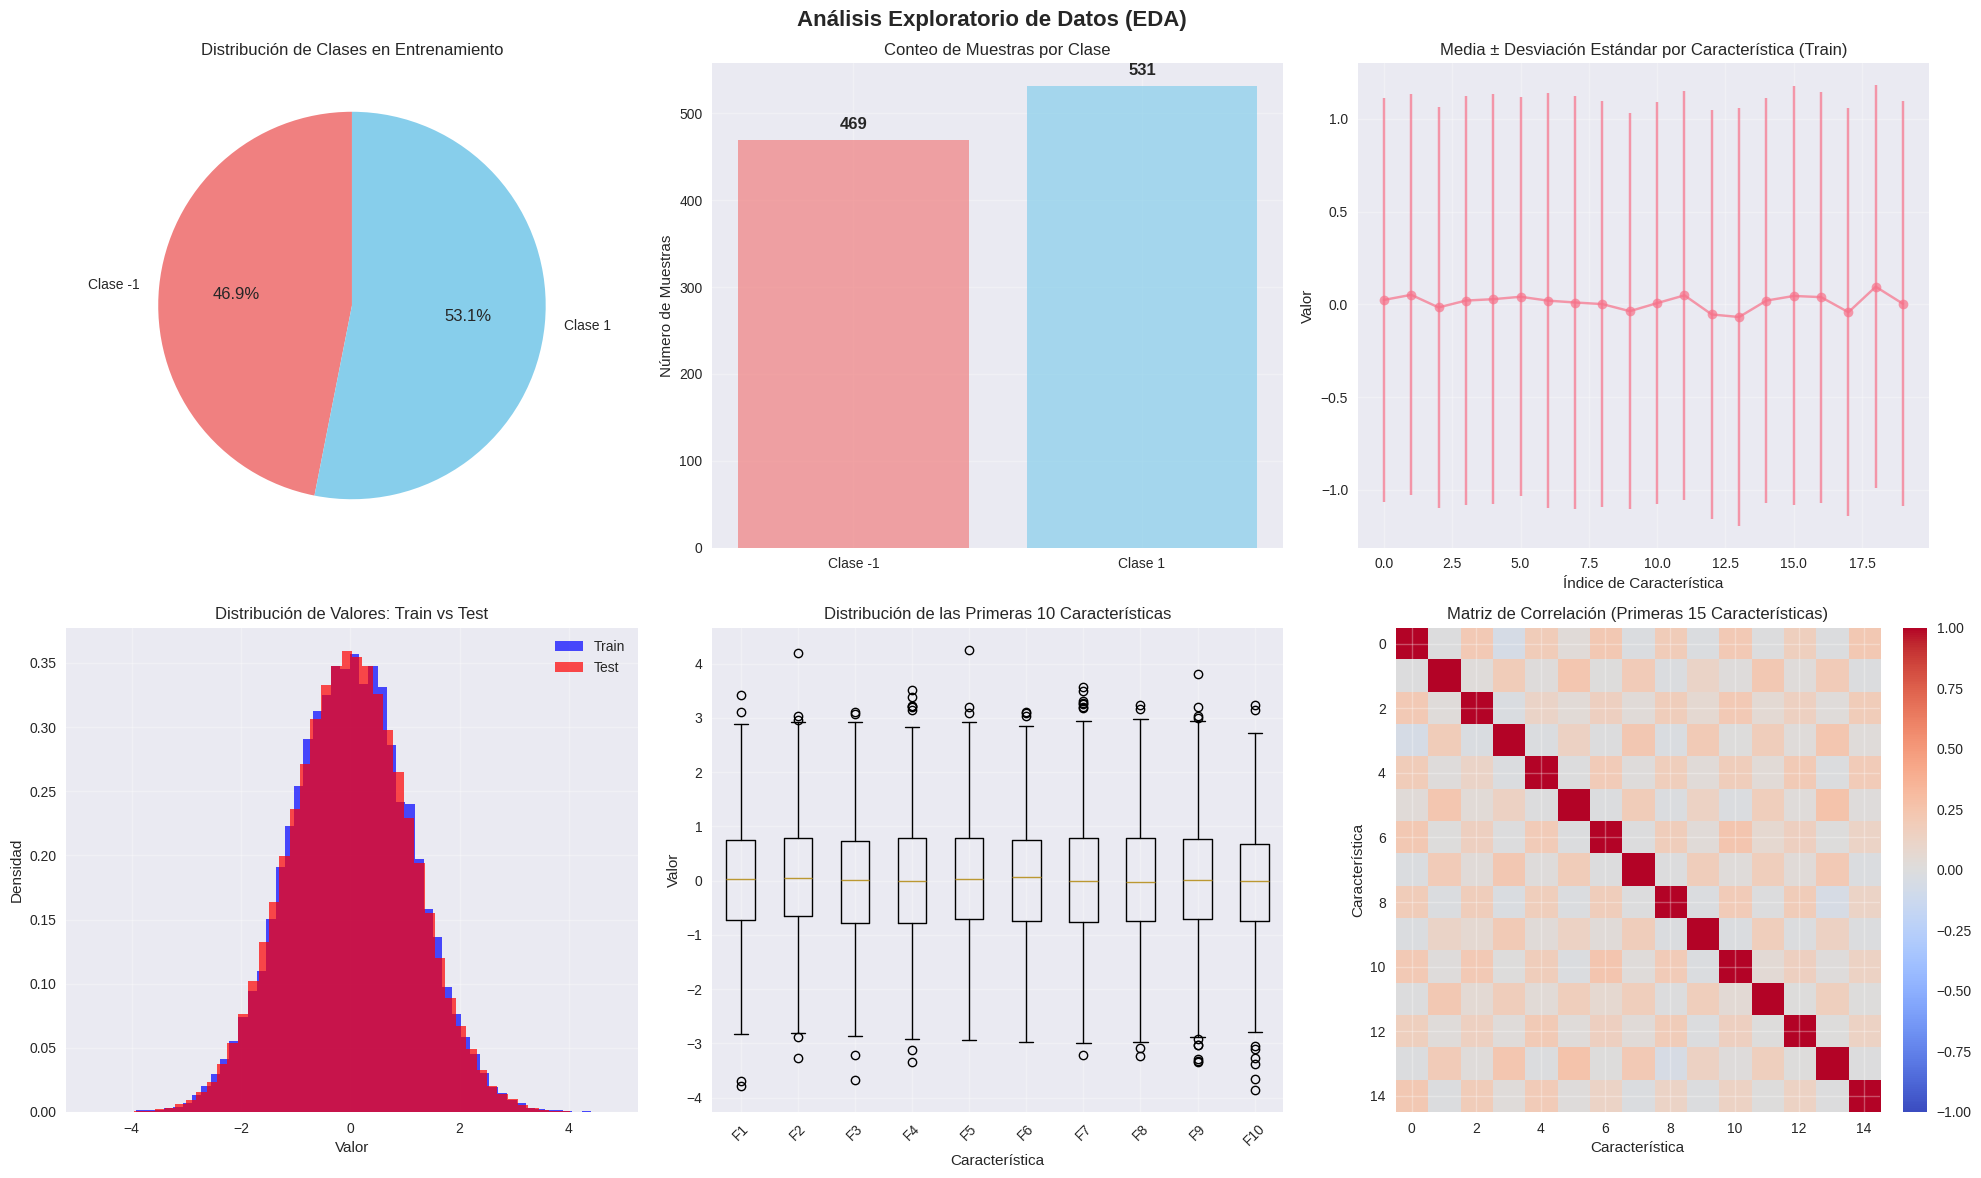


RESUMEN ESTADÍSTICO DEL DATASET
Conjunto de entrenamiento:
  - Tamaño: 1,000 muestras, 20 características
  - Rango de valores: [-4.0843, 4.4016]
  - Media global: 0.0117
  - Desviación estándar global: 1.0977

Conjunto de prueba:
  - Tamaño: 10,000 muestras, 20 características
  - Rango de valores: [-4.7194, 4.7795]
  - Media global: 0.0028
  - Desviación estándar global: 1.0958

Balance de clases:
  - Clase -1: 469 muestras (46.9%)
  - Clase 1: 531 muestras (53.1%)

Ratio de balance: 0.883 (Balanceado)


In [4]:
# ================================
# VISUALIZACIONES EDA - DISTRIBUCIÓN DE CLASES Y DATOS
# ================================

# Crear figura con subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis Exploratorio de Datos (EDA)', fontsize=16, fontweight='bold')

# 1. Distribución de clases
axes[0,0].pie(class_counts, labels=[f'Clase {c}' for c in unique_classes], 
              autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
axes[0,0].set_title('Distribución de Clases en Entrenamiento')

# 2. Histograma de clases
axes[0,1].bar([f'Clase {c}' for c in unique_classes], class_counts, 
              color=['lightcoral', 'skyblue'], alpha=0.7)
axes[0,1].set_title('Conteo de Muestras por Clase')
axes[0,1].set_ylabel('Número de Muestras')
for i, v in enumerate(class_counts):
    axes[0,1].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

# 3. Estadísticas de características de entrenamiento
feature_means_train = X_train.mean(axis=0)
feature_stds_train = X_train.std(axis=0)
feature_indices = np.arange(min(20, X_train.shape[1]))  # Mostrar máximo 20 características

axes[0,2].errorbar(feature_indices, feature_means_train[:len(feature_indices)], 
                   yerr=feature_stds_train[:len(feature_indices)], 
                   fmt='o-', capsize=3, alpha=0.7)
axes[0,2].set_title('Media ± Desviación Estándar por Característica (Train)')
axes[0,2].set_xlabel('Índice de Característica')
axes[0,2].set_ylabel('Valor')
axes[0,2].grid(True, alpha=0.3)

# 4. Comparación de distribuciones Train vs Test
axes[1,0].hist(X_train.flatten(), bins=50, alpha=0.7, label='Train', density=True, color='blue')
axes[1,0].hist(X_test.flatten(), bins=50, alpha=0.7, label='Test', density=True, color='red')
axes[1,0].set_title('Distribución de Valores: Train vs Test')
axes[1,0].set_xlabel('Valor')
axes[1,0].set_ylabel('Densidad')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Boxplot de características (muestra de las primeras 10)
sample_features = X_train[:, :min(10, X_train.shape[1])]
axes[1,1].boxplot(sample_features, labels=[f'F{i+1}' for i in range(sample_features.shape[1])])
axes[1,1].set_title('Distribución de las Primeras 10 Características')
axes[1,1].set_xlabel('Característica')
axes[1,1].set_ylabel('Valor')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Matriz de correlación (muestra de las primeras 15 características)
n_features_corr = min(15, X_train.shape[1])
corr_matrix = np.corrcoef(X_train[:, :n_features_corr].T)
im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1,2].set_title('Matriz de Correlación (Primeras 15 Características)')
axes[1,2].set_xlabel('Característica')
axes[1,2].set_ylabel('Característica')
plt.colorbar(im, ax=axes[1,2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("\nRESUMEN ESTADÍSTICO DEL DATASET")
print("="*50)
print(f"Conjunto de entrenamiento:")
print(f"  - Tamaño: {X_train.shape[0]:,} muestras, {X_train.shape[1]} características")
print(f"  - Rango de valores: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"  - Media global: {X_train.mean():.4f}")
print(f"  - Desviación estándar global: {X_train.std():.4f}")

print(f"\nConjunto de prueba:")
print(f"  - Tamaño: {X_test.shape[0]:,} muestras, {X_test.shape[1]} características")
print(f"  - Rango de valores: [{X_test.min():.4f}, {X_test.max():.4f}]")
print(f"  - Media global: {X_test.mean():.4f}")
print(f"  - Desviación estándar global: {X_test.std():.4f}")

print(f"\nBalance de clases:")
for clase, count in zip(unique_classes, class_counts):
    print(f"  - Clase {clase}: {count:,} muestras ({count/len(y_train)*100:.1f}%)")

balance_ratio = min(class_counts) / max(class_counts)
print(f"\nRatio de balance: {balance_ratio:.3f} ({'Balanceado' if balance_ratio > 0.8 else 'Desbalanceado'})")

ANÁLISIS DE REDUCCIÓN DIMENSIONAL
Calculando t-SNE (esto puede tomar unos minutos)...


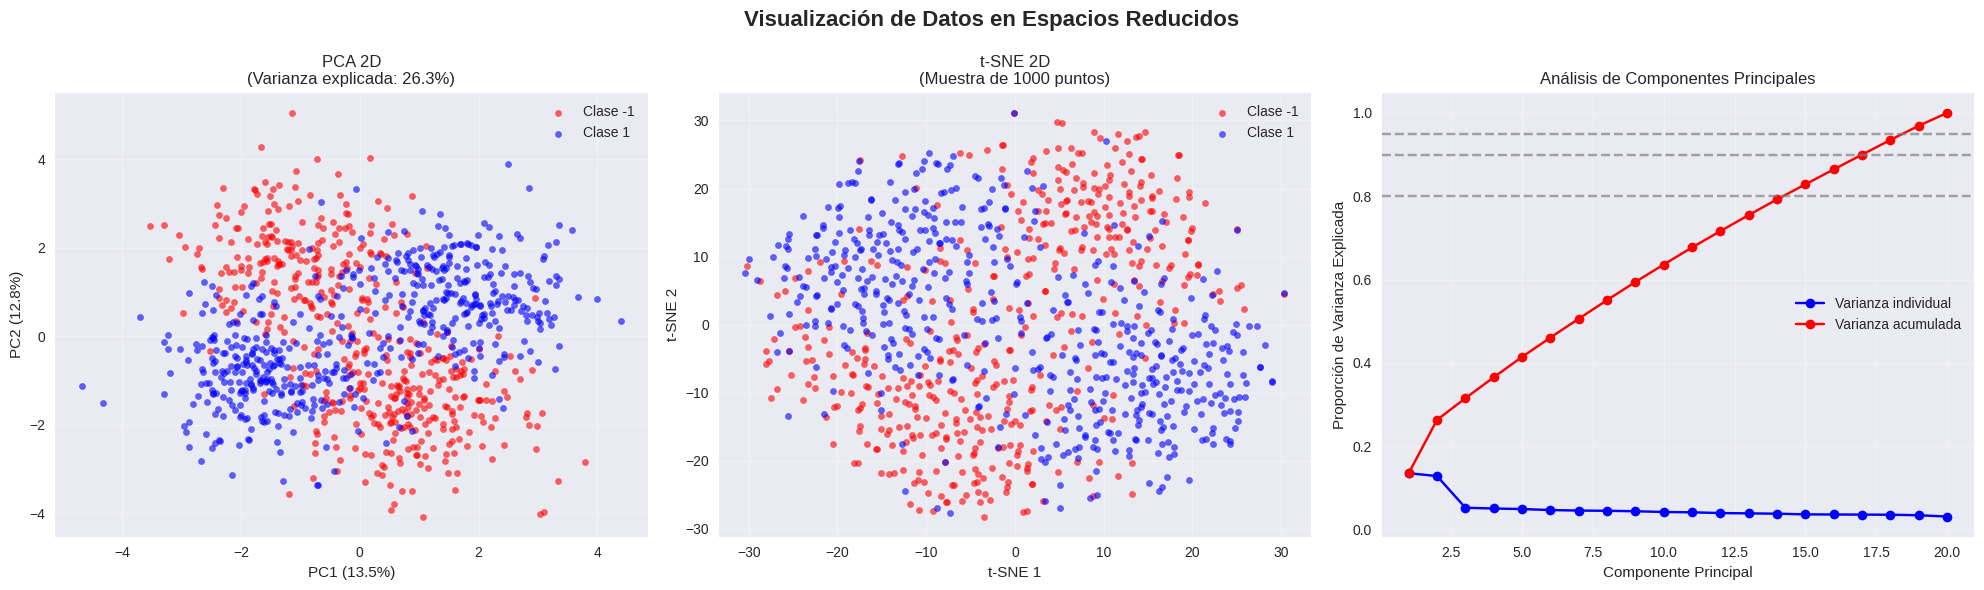


INFORMACIÓN DE PCA:
- Primeras 2 componentes explican: 26.3% de la varianza
- Para explicar 80% de varianza se necesitan: 15 componentes
- Para explicar 90% de varianza se necesitan: 18 componentes
- Para explicar 95% de varianza se necesitan: 19 componentes

SEPARABILIDAD DE CLASES:
- Distancia entre centroides en PCA: 0.086
- Distancia entre centroides en t-SNE: 1.237

Las clases están entremezcladas en el espacio PCA


In [5]:
# ================================
# VISUALIZACIONES EDA - REDUCCIÓN DIMENSIONAL
# ================================

print("ANÁLISIS DE REDUCCIÓN DIMENSIONAL")
print("="*50)

# Aplicar PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Aplicar t-SNE
print("Calculando t-SNE (esto puede tomar unos minutos)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# Usar una muestra para t-SNE si hay muchos datos
sample_size = min(1000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_train_sample = X_train_scaled[sample_indices]
y_train_sample = y_train[sample_indices]
X_train_tsne = tsne.fit_transform(X_train_sample)

# Crear visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Visualización de Datos en Espacios Reducidos', fontsize=16, fontweight='bold')

# Definir colores para las clases
colors = ['red', 'blue']
class_labels = [f'Clase {int(c)}' for c in unique_classes]

# 1. PCA 2D
for i, clase in enumerate(unique_classes):
    mask = y_train == clase
    axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   c=colors[i], label=class_labels[i], alpha=0.6, s=20)
axes[0].set_title(f'PCA 2D\n(Varianza explicada: {pca.explained_variance_ratio_.sum():.1%})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. t-SNE 2D
for i, clase in enumerate(unique_classes):
    mask = y_train_sample == clase
    axes[1].scatter(X_train_tsne[mask, 0], X_train_tsne[mask, 1], 
                   c=colors[i], label=class_labels[i], alpha=0.6, s=20)
axes[1].set_title(f't-SNE 2D\n(Muestra de {sample_size} puntos)')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Scree plot de PCA (varianza explicada)
pca_full = PCA()
pca_full.fit(X_train_scaled)
n_components_plot = min(20, len(pca_full.explained_variance_ratio_))
cumvar = np.cumsum(pca_full.explained_variance_ratio_[:n_components_plot])

axes[2].plot(range(1, n_components_plot + 1), pca_full.explained_variance_ratio_[:n_components_plot], 
             'bo-', label='Varianza individual')
axes[2].plot(range(1, n_components_plot + 1), cumvar, 'ro-', label='Varianza acumulada')
axes[2].set_title('Análisis de Componentes Principales')
axes[2].set_xlabel('Componente Principal')
axes[2].set_ylabel('Proporción de Varianza Explicada')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Añadir líneas de referencia para varianza acumulada
axes[2].axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='80% varianza')
axes[2].axhline(y=0.9, color='gray', linestyle='--', alpha=0.7, label='90% varianza')
axes[2].axhline(y=0.95, color='gray', linestyle='--', alpha=0.7, label='95% varianza')

plt.tight_layout()
plt.show()

# Información adicional sobre PCA
print(f"\nINFORMACIÓN DE PCA:")
print(f"- Primeras 2 componentes explican: {pca.explained_variance_ratio_.sum():.1%} de la varianza")
print(f"- Para explicar 80% de varianza se necesitan: {np.argmax(cumvar >= 0.8) + 1} componentes")
print(f"- Para explicar 90% de varianza se necesitan: {np.argmax(cumvar >= 0.9) + 1} componentes")
print(f"- Para explicar 95% de varianza se necesitan: {np.argmax(cumvar >= 0.95) + 1} componentes")

print(f"\nSEPARABILIDAD DE CLASES:")
# Calcular distancia entre centroides en espacio PCA
centroids = []
for clase in unique_classes:
    mask = y_train == clase
    centroid = X_train_pca[mask].mean(axis=0)
    centroids.append(centroid)

distance_pca = np.linalg.norm(centroids[0] - centroids[1])
print(f"- Distancia entre centroides en PCA: {distance_pca:.3f}")

# Calcular separabilidad en t-SNE
centroids_tsne = []
for clase in unique_classes:
    mask = y_train_sample == clase
    centroid = X_train_tsne[mask].mean(axis=0)
    centroids_tsne.append(centroid)

distance_tsne = np.linalg.norm(centroids_tsne[0] - centroids_tsne[1])
print(f"- Distancia entre centroides en t-SNE: {distance_tsne:.3f}")

print(f"\nLas clases {'parecen separables' if distance_pca > 2 else 'están entremezcladas'} en el espacio PCA")

## Parte 2: Configuración Extensiva de Modelos de Clustering

**Objetivo**: Entrenar múltiples configuraciones de cada algoritmo para evaluación semi-supervisada completa.

In [6]:
# ================================
# CONFIGURACIÓN DE EXPERIMENTOS
# ================================

print("CONFIGURANDO EXPERIMENTOS DE CLUSTERING")
print("="*60)

# Configuraciones para cada algoritmo
clustering_configs = {
    'kmeans': {
        'n_clusters': [2, 3, 4, 5, 6, 7, 8],
        'n_init': [10],
        'random_state': [42]
    },
    'hierarchical': {
        'n_clusters': [2, 3, 4, 5, 6, 7, 8],
        'linkage': ['ward', 'complete', 'average', 'single']
    },
    'dbscan': {
        'eps': [0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0],
        'min_samples': [3, 4, 5, 6, 8, 10]
    }
}

# Generar todas las combinaciones
all_models = []

# K-means
for n_clusters, n_init, random_state in product(
    clustering_configs['kmeans']['n_clusters'],
    clustering_configs['kmeans']['n_init'],
    clustering_configs['kmeans']['random_state']
):
    all_models.append({
        'algorithm': 'kmeans',
        'model': KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state),
        'params': {'n_clusters': n_clusters, 'n_init': n_init, 'random_state': random_state},
        'name': f'KMeans_K{n_clusters}'
    })

# Clustering Jerárquico
for n_clusters, linkage in product(
    clustering_configs['hierarchical']['n_clusters'],
    clustering_configs['hierarchical']['linkage']
):
    all_models.append({
        'algorithm': 'hierarchical',
        'model': AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage),
        'params': {'n_clusters': n_clusters, 'linkage': linkage},
        'name': f'Hierarchical_{linkage}_K{n_clusters}'
    })

# DBSCAN
for eps, min_samples in product(
    clustering_configs['dbscan']['eps'],
    clustering_configs['dbscan']['min_samples']
):
    all_models.append({
        'algorithm': 'dbscan',
        'model': DBSCAN(eps=eps, min_samples=min_samples),
        'params': {'eps': eps, 'min_samples': min_samples},
        'name': f'DBSCAN_eps{eps}_min{min_samples}'
    })

print(f"Total de modelos configurados: {len(all_models)}")
print(f"  - K-means: {len([m for m in all_models if m['algorithm'] == 'kmeans'])}")
print(f"  - Jerárquico: {len([m for m in all_models if m['algorithm'] == 'hierarchical'])}")
print(f"  - DBSCAN: {len([m for m in all_models if m['algorithm'] == 'dbscan'])}")

CONFIGURANDO EXPERIMENTOS DE CLUSTERING
Total de modelos configurados: 83
  - K-means: 7
  - Jerárquico: 28
  - DBSCAN: 48


## Parte 3: Entrenamiento y Evaluación No Supervisada

**Objetivo**: Entrenar todos los modelos y calcular métricas no supervisadas básicas.

In [ ]:
# ================================
# ENTRENAMIENTO DE TODOS LOS MODELOS
# ================================

print("ENTRENANDO TODOS LOS MODELOS DE CLUSTERING")
print("="*60)

results = []

for i, model_config in enumerate(all_models):
    print(f"\rProcesando modelo {i+1}/{len(all_models)}: {model_config['name']}", end='', flush=True)
    
    try:
        # Entrenar el modelo
        labels = model_config['model'].fit_predict(X_test_scaled)
        
        # Calcular métricas no supervisadas
        n_clusters = len(np.unique(labels))
        n_noise = np.sum(labels == -1) if -1 in labels else 0
        
        # Solo calcular métricas si hay al menos 2 clusters válidos
        if n_clusters >= 2:
            # Filtrar ruido para métricas
            if -1 in labels:
                mask = labels != -1
                if mask.sum() > 1 and len(np.unique(labels[mask])) >= 2:
                    X_filtered = X_test_scaled[mask]
                    labels_filtered = labels[mask]
                    silhouette = silhouette_score(X_filtered, labels_filtered)
                    calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)
                    davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                else:
                    silhouette = calinski_harabasz = davies_bouldin = np.nan
            else:
                silhouette = silhouette_score(X_test_scaled, labels)
                calinski_harabasz = calinski_harabasz_score(X_test_scaled, labels)
                davies_bouldin = davies_bouldin_score(X_test_scaled, labels)
        else:
            silhouette = calinski_harabasz = davies_bouldin = np.nan
        
        # Guardar resultados
        result = {
            'model_id': i,
            'name': model_config['name'],
            'algorithm': model_config['algorithm'],
            'params': model_config['params'],
            'model': model_config['model'],
            'labels': labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'calinski_harabasz': calinski_harabasz,
            'davies_bouldin': davies_bouldin,
            'valid': not np.isnan(silhouette)
        }
        
        results.append(result)
        
    except Exception as e:
        print(f"\nError en modelo {model_config['name']}: {e}")
        # Guardar resultado con error
        result = {
            'model_id': i,
            'name': model_config['name'],
            'algorithm': model_config['algorithm'],
            'params': model_config['params'],
            'model': model_config['model'],
            'labels': None,
            'n_clusters': 0,
            'n_noise': 0,
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan,
            'valid': False,
            'error': str(e)
        }
        results.append(result)

print(f"\n\nEntrenamiento completado!")
valid_results = [r for r in results if r['valid']]
print(f"Modelos válidos: {len(valid_results)}/{len(results)}")

# Resumen por algoritmo
for algo in ['kmeans', 'hierarchical', 'dbscan']:
    algo_results = [r for r in valid_results if r['algorithm'] == algo]
    print(f"  - {algo}: {len(algo_results)} modelos válidos")

ENTRENANDO TODOS LOS MODELOS DE CLUSTERING
Procesando modelo 7/83: KMeans_K8

## Parte 4: Evaluación Semi-supervisada de TODOS los Modelos

**Objetivo**: Aplicar evaluación semi-supervisada a todos los modelos válidos, no solo a los mejores.

In [ ]:
# ================================
# FUNCIÓN PARA ETIQUETADO DE CLUSTERS
# ================================

def label_clusters_majority_vote(cluster_labels, true_labels):
    """
    Etiqueta cada cluster según la clase mayoritaria
    """
    from collections import Counter
    
    cluster_mapping = {}
    cluster_purity = {}
    predicted_labels = np.copy(cluster_labels)
    
    # Obtener clusters únicos (excluyendo ruido)
    unique_clusters = np.unique(cluster_labels)
    if -1 in unique_clusters:
        unique_clusters = unique_clusters[unique_clusters != -1]
    
    for cluster_id in unique_clusters:
        # Obtener muestras del cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[cluster_mask]
        
        if len(cluster_true_labels) > 0:
            # Encontrar la clase mayoritaria
            label_counts = Counter(cluster_true_labels)
            majority_label = label_counts.most_common(1)[0][0]
            majority_count = label_counts.most_common(1)[0][1]
            
            # Calcular pureza del cluster
            purity = majority_count / len(cluster_true_labels)
            
            # Guardar mapeo y pureza
            cluster_mapping[cluster_id] = majority_label
            cluster_purity[cluster_id] = purity
            
            # Asignar etiqueta mayoritaria
            predicted_labels[cluster_mask] = majority_label
    
    # Para puntos de ruido, asignar etiqueta más común
    if -1 in cluster_labels:
        noise_mask = cluster_labels == -1
        most_common_label = Counter(true_labels).most_common(1)[0][0]
        predicted_labels[noise_mask] = most_common_label
        cluster_mapping[-1] = most_common_label
        cluster_purity[-1] = 0.0
    
    return predicted_labels, cluster_mapping, cluster_purity

In [ ]:
# ================================
# EVALUACIÓN SEMI-SUPERVISADA COMPLETA
# ================================

print("APLICANDO EVALUACIÓN SEMI-SUPERVISADA A TODOS LOS MODELOS VÁLIDOS")
print("="*70)
print("METODOLOGÍA:")
print("1. Modelos entrenados con X_test_scaled (x_prueba)")
print("2. Evaluación usando X_train_scaled (x_entrena) y y_train (y_entrena)")
print("3. Etiquetado de clusters por mayoría de votos")
print("4. Cálculo de métricas supervisadas")
print("="*70)

# Aplicar evaluación semi-supervisada a todos los modelos válidos
for i, result in enumerate(valid_results):
    print(f"\rProcesando evaluación semi-supervisada {i+1}/{len(valid_results)}: {result['name']}", 
          end='', flush=True)
    
    try:
        # PASO 1: Obtener predicciones del modelo entrenado sobre X_train_scaled
        if result['algorithm'] == 'kmeans':
            # Para K-means: usar predict()
            train_labels = result['model'].predict(X_train_scaled)
        elif result['algorithm'] == 'hierarchical':
            # Para clustering jerárquico: usar fit_predict() sobre X_train_scaled
            from sklearn.cluster import AgglomerativeClustering
            # Recrear el modelo con los mismos parámetros
            temp_model = AgglomerativeClustering(**result['params'])
            train_labels = temp_model.fit_predict(X_train_scaled)
        elif result['algorithm'] == 'dbscan':
            # Para DBSCAN: usar kneighbors para asignar puntos
            from sklearn.neighbors import NearestNeighbors
            # Obtener los puntos core del modelo original
            core_samples = result['model'].core_sample_indices_
            if len(core_samples) > 0:
                # Usar vecinos más cercanos para asignar etiquetas
                nbrs = NearestNeighbors(n_neighbors=1).fit(X_test_scaled[core_samples])
                distances, indices = nbrs.kneighbors(X_train_scaled)
                train_labels = result['labels'][core_samples[indices.flatten()]]
            else:
                # Si no hay core samples, asignar todo como ruido
                train_labels = np.full(len(X_train_scaled), -1)
        
        # PASO 2: Etiquetado por voto mayoritario usando las etiquetas de entrenamiento
        predicted_labels, cluster_mapping, cluster_purity = label_clusters_majority_vote(
            train_labels, y_train
        )
        
        # PASO 3: Métricas semi-supervisadas
        accuracy = accuracy_score(y_train, predicted_labels)
        ari = adjusted_rand_score(y_train, train_labels)
        nmi = normalized_mutual_info_score(y_train, train_labels)
        
        # PASO 4: Pureza promedio ponderada
        total_samples = len(y_train)
        weighted_purity = 0
        for cluster_id, purity in cluster_purity.items():
            if cluster_id != -1:  # Excluir ruido
                cluster_size = np.sum(train_labels == cluster_id)
                if cluster_size > 0:
                    weighted_purity += purity * (cluster_size / total_samples)
        
        # PASO 5: Calcular matriz de confusión y métricas derivadas
        from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
        
        # Matriz de confusión
        cm = confusion_matrix(y_train, predicted_labels)
        
        # Métricas clásicas de clasificación
        precision = precision_score(y_train, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(y_train, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(y_train, predicted_labels, average='weighted', zero_division=0)
        
        # Especificidad y sensibilidad por clase (para caso binario)
        if len(np.unique(y_train)) == 2:
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall de clase positiva
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Especificidad
        else:
            sensitivity = recall  # Para múltiples clases usar recall promedio
            specificity = recall
        
        # Actualizar resultado
        result.update({
            'train_labels': train_labels,
            'predicted_labels': predicted_labels,
            'cluster_mapping': cluster_mapping,
            'cluster_purity': cluster_purity,
            'confusion_matrix': cm,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ari': ari,
            'nmi': nmi,
            'weighted_purity': weighted_purity
        })
        
    except Exception as e:
        print(f"\nError en evaluación semi-supervisada de {result['name']}: {e}")
        result.update({
            'confusion_matrix': np.array([[0, 0], [0, 0]]),
            'accuracy': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'f1_score': np.nan,
            'sensitivity': np.nan,
            'specificity': np.nan,
            'ari': np.nan,
            'nmi': np.nan,
            'weighted_purity': np.nan,
            'semi_supervised_error': str(e)
        })

print(f"\n\nEvaluación semi-supervisada completada para {len(valid_results)} modelos")

# Filtrar modelos con evaluación completa
complete_results = [model for model in valid_results 
                   if 'f1_score' in model and not np.isnan(model['f1_score'])]

print(f"Modelos con evaluación completa: {len(complete_results)}")

# Mostrar algunos resultados
if len(complete_results) > 0:
    print(f"\nTop 3 modelos por F1-Score:")
    sorted_models = sorted(complete_results, key=lambda x: x['f1_score'], reverse=True)
    for i, model in enumerate(sorted_models[:3]):
        print(f"  {i+1}. {model['name']} ({model['algorithm']}): F1={model['f1_score']:.4f}")
        print(f"     - Accuracy: {model['accuracy']:.4f}, Precision: {model['precision']:.4f}")
        print(f"     - Recall: {model['recall']:.4f}, Silhouette: {model['silhouette']:.4f}")

APLICANDO EVALUACIÓN SEMI-SUPERVISADA A TODOS LOS MODELOS VÁLIDOS
METODOLOGÍA:
1. Modelos entrenados con X_test_scaled (x_prueba)
2. Evaluación usando X_train_scaled (x_entrena) y y_train (y_entrena)
3. Etiquetado de clusters por mayoría de votos
4. Cálculo de métricas supervisadas
Procesando evaluación semi-supervisada 45/45: DBSCAN_eps3.0_min10_K888

Evaluación semi-supervisada completada para 45 modelos
Modelos con evaluación completa: 45

Top 3 modelos por F1-Score:
  1. KMeans_K4 (kmeans): F1=0.8510
     - Accuracy: 0.8510, Precision: 0.8510
     - Recall: 0.8510, Silhouette: 0.0667
  2. KMeans_K5 (kmeans): F1=0.8501
     - Accuracy: 0.8500, Precision: 0.8554
     - Recall: 0.8500, Silhouette: 0.0556
  3. KMeans_K8 (kmeans): F1=0.8411
     - Accuracy: 0.8410, Precision: 0.8412
     - Recall: 0.8410, Silhouette: 0.0347


## Parte 5: Selección del Mejor Modelo por Tipo

**Objetivo**: Seleccionar el mejor modelo de cada tipo (K-means, Jerárquico, DBSCAN) basado en métricas semi-supervisadas.

In [ ]:
# ================================
# SELECCIÓN DEL MEJOR MODELO POR TIPO
# ================================

print("SELECCIONANDO EL MEJOR MODELO DE CADA TIPO")
print("="*60)

# Filtrar resultados válidos con métricas semi-supervisadas
complete_results = [r for r in valid_results if not np.isnan(r.get('accuracy', np.nan))]
print(f"Modelos con evaluación completa: {len(complete_results)}")

# Seleccionar mejor modelo por tipo usando F1-Score
best_models_by_type = {}

for algorithm in ['kmeans', 'hierarchical', 'dbscan']:
    algorithm_results = [r for r in complete_results if r['algorithm'] == algorithm]
    
    if algorithm_results:
        # Ordenar por F1-Score (métrica clásica más interpretable)
        algorithm_results.sort(key=lambda x: x['f1_score'], reverse=True)
        best_model = algorithm_results[0]
        best_models_by_type[algorithm] = best_model
        
        print(f"\nMejor modelo {algorithm.upper()}:")
        print(f"  Nombre: {best_model['name']}")
        print(f"  Parámetros: {best_model['params']}")
        print(f"  Accuracy: {best_model['accuracy']:.4f}")
        print(f"  Silhouette: {best_model['silhouette']:.4f}")
        print(f"  ARI: {best_model['ari']:.4f}")
        print(f"  NMI: {best_model['nmi']:.4f}")
        print(f"  F1-Score: {best_model['f1_score']:.4f}")
        print(f"  Clusters: {best_model['n_clusters']}, Ruido: {best_model['n_noise']}")
        
        # Top 5 modelos del tipo
        print(f"\n  Top 5 modelos {algorithm}:")
        for j, model in enumerate(algorithm_results[:5]):
            print(f"    {j+1}. {model['name']}: F1={model['f1_score']:.4f}, "
                  f"Acc={model['accuracy']:.4f}, Sil={model['silhouette']:.4f}")
    else:
        print(f"\nNo hay modelos válidos para {algorithm}")

print(f"\nSelección completada. Mejores modelos por tipo: {len(best_models_by_type)}")

SELECCIONANDO EL MEJOR MODELO DE CADA TIPO
Modelos con evaluación completa: 45

Mejor modelo KMEANS:
  Nombre: KMeans_K4
  Parámetros: {'n_clusters': 4, 'n_init': 10, 'random_state': 42}
  Accuracy: 0.8510
  Silhouette: 0.0667
  ARI: 0.2452
  NMI: 0.2613
  F1-Score: 0.8510
  Clusters: 4, Ruido: 0

  Top 5 modelos kmeans:
    1. KMeans_K4: F1=0.8510, Acc=0.8510, Sil=0.0667
    2. KMeans_K5: F1=0.8501, Acc=0.8500, Sil=0.0556
    3. KMeans_K8: F1=0.8411, Acc=0.8410, Sil=0.0347
    4. KMeans_K7: F1=0.8350, Acc=0.8350, Sil=0.0394
    5. KMeans_K6: F1=0.8214, Acc=0.8230, Sil=0.0452

Mejor modelo HIERARCHICAL:
  Nombre: Hierarchical_ward_K4
  Parámetros: {'n_clusters': 4, 'linkage': 'ward'}
  Accuracy: 0.7590
  Silhouette: 0.0429
  ARI: 0.1352
  NMI: 0.1625
  F1-Score: 0.7528
  Clusters: 4, Ruido: 0

  Top 5 modelos hierarchical:
    1. Hierarchical_ward_K4: F1=0.7528, Acc=0.7590, Sil=0.0429
    2. Hierarchical_ward_K5: F1=0.7528, Acc=0.7590, Sil=0.0276
    3. Hierarchical_ward_K6: F1=0.7528,

## Parte 6: Comparación Final y Selección del Modelo Óptimo

**Objetivo**: Comparar los mejores modelos de cada tipo y seleccionar el modelo final.

In [ ]:
# ================================
# COMPARACIÓN FINAL DE MEJORES MODELOS
# ================================

print("COMPARACIÓN FINAL DE LOS MEJORES MODELOS POR TIPO")
print("="*70)

# Crear tabla comparativa
comparison_data = []

for algorithm, best_model in best_models_by_type.items():
    comparison_data.append({
        'Algoritmo': algorithm.upper(),
        'Configuración': best_model['name'],
        'Parámetros': str(best_model['params']),
        'Accuracy': f"{best_model['accuracy']:.4f}",
        'Precision': f"{best_model['precision']:.4f}",
        'Recall': f"{best_model['recall']:.4f}",
        'F1_Score': f"{best_model['f1_score']:.4f}",
        'Sensitivity': f"{best_model['sensitivity']:.4f}",
        'Specificity': f"{best_model['specificity']:.4f}",
        'Silhouette': f"{best_model['silhouette']:.4f}",
        'N_Clusters': best_model['n_clusters'],
        'N_Ruido': best_model['n_noise']
    })

# Mostrar tabla comparativa
df_comparison = pd.DataFrame(comparison_data)
print("\nTabla Comparativa de Mejores Modelos:")
print(df_comparison.to_string(index=False))

# Seleccionar modelo final basado en F1-Score
final_best_model = max(best_models_by_type.values(), key=lambda x: x['f1_score'])

print(f"\nMODELO FINAL SELECCIONADO:")
print(f"="*40)
print(f"Algoritmo: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")
print(f"Parámetros: {final_best_model['params']}")
print(f"F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:")
print(f"  - Accuracy: {final_best_model['accuracy']:.4f}")
print(f"  - Precision: {final_best_model['precision']:.4f}")
print(f"  - Recall (Sensitivity): {final_best_model['recall']:.4f}")
print(f"  - Specificity: {final_best_model['specificity']:.4f}")
print(f"  - F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MÉTRICAS DE CLUSTERING:")
print(f"  - Silhouette Score: {final_best_model['silhouette']:.4f}")
print(f"  - Adjusted Rand Index: {final_best_model['ari']:.4f}")
print(f"  - Normalized Mutual Info: {final_best_model['nmi']:.4f}")
print(f"")
print(f"ESTRUCTURA DE CLUSTERS:")
print(f"  - Número de clusters: {final_best_model['n_clusters']}")
print(f"  - Puntos de ruido: {final_best_model['n_noise']}")

# Mostrar matriz de confusión del modelo final
print(f"\nMATRIZ DE CONFUSIÓN:")
cm = final_best_model['confusion_matrix']
print(f"                  Predicho")
print(f"                -1    +1")
print(f"Real      -1   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"          +1   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Interpretar matriz de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\nINTERPRETACIÓN DE LA MATRIZ:")
print(f"  - Verdaderos Negativos (TN): {tn}")
print(f"  - Falsos Positivos (FP): {fp}")
print(f"  - Falsos Negativos (FN): {fn}")
print(f"  - Verdaderos Positivos (TP): {tp}")
print(f"  - Tasa de Error: {(fp + fn) / (tn + fp + fn + tp):.4f}")
print(f"  - Tasa de Acierto: {(tn + tp) / (tn + fp + fn + tp):.4f}")

# Mapeo de clusters del modelo final
print(f"\nMapeo de Clusters del Modelo Final:")
for cluster_id, label in final_best_model['cluster_mapping'].items():
    purity = final_best_model['cluster_purity'][cluster_id]
    cluster_size = np.sum(final_best_model['labels'] == cluster_id)
    if cluster_id == -1:
        print(f"  Ruido -> Clase {label} | {cluster_size} muestras (pureza: {purity:.3f})")
    else:
        print(f"  Cluster {cluster_id} -> Clase {label} | {cluster_size} muestras (pureza: {purity:.3f})")

COMPARACIÓN FINAL DE LOS MEJORES MODELOS POR TIPO

Tabla Comparativa de Mejores Modelos:
   Algoritmo        Configuración                                          Parámetros Accuracy Precision Recall F1_Score Sensitivity Specificity Silhouette  N_Clusters  N_Ruido
      KMEANS            KMeans_K4 {'n_clusters': 4, 'n_init': 10, 'random_state': 42}   0.8510    0.8510 0.8510   0.8510      0.8606      0.8401     0.0667           4        0
HIERARCHICAL Hierarchical_ward_K4                {'n_clusters': 4, 'linkage': 'ward'}   0.7590    0.7739 0.7590   0.7528      0.8945      0.6055     0.0429           4        0
      DBSCAN   DBSCAN_eps2.5_min3                      {'eps': 2.5, 'min_samples': 3}   0.7290    0.7292 0.7290   0.7278      0.7834      0.6674     0.0821          60     9680

MODELO FINAL SELECCIONADO:
Algoritmo: KMEANS
Configuración: KMeans_K4
Parámetros: {'n_clusters': 4, 'n_init': 10, 'random_state': 42}
F1-Score: 0.8510

MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:
  - Accuracy: 

## Parte 6.1: Visualizaciones de Análisis de Modelos

**Objetivo**: Visualizar métricas de rendimiento, método del codo, dendrogramas y análisis de silhouette.

GENERANDO VISUALIZACIONES DE ANÁLISIS DE MODELOS


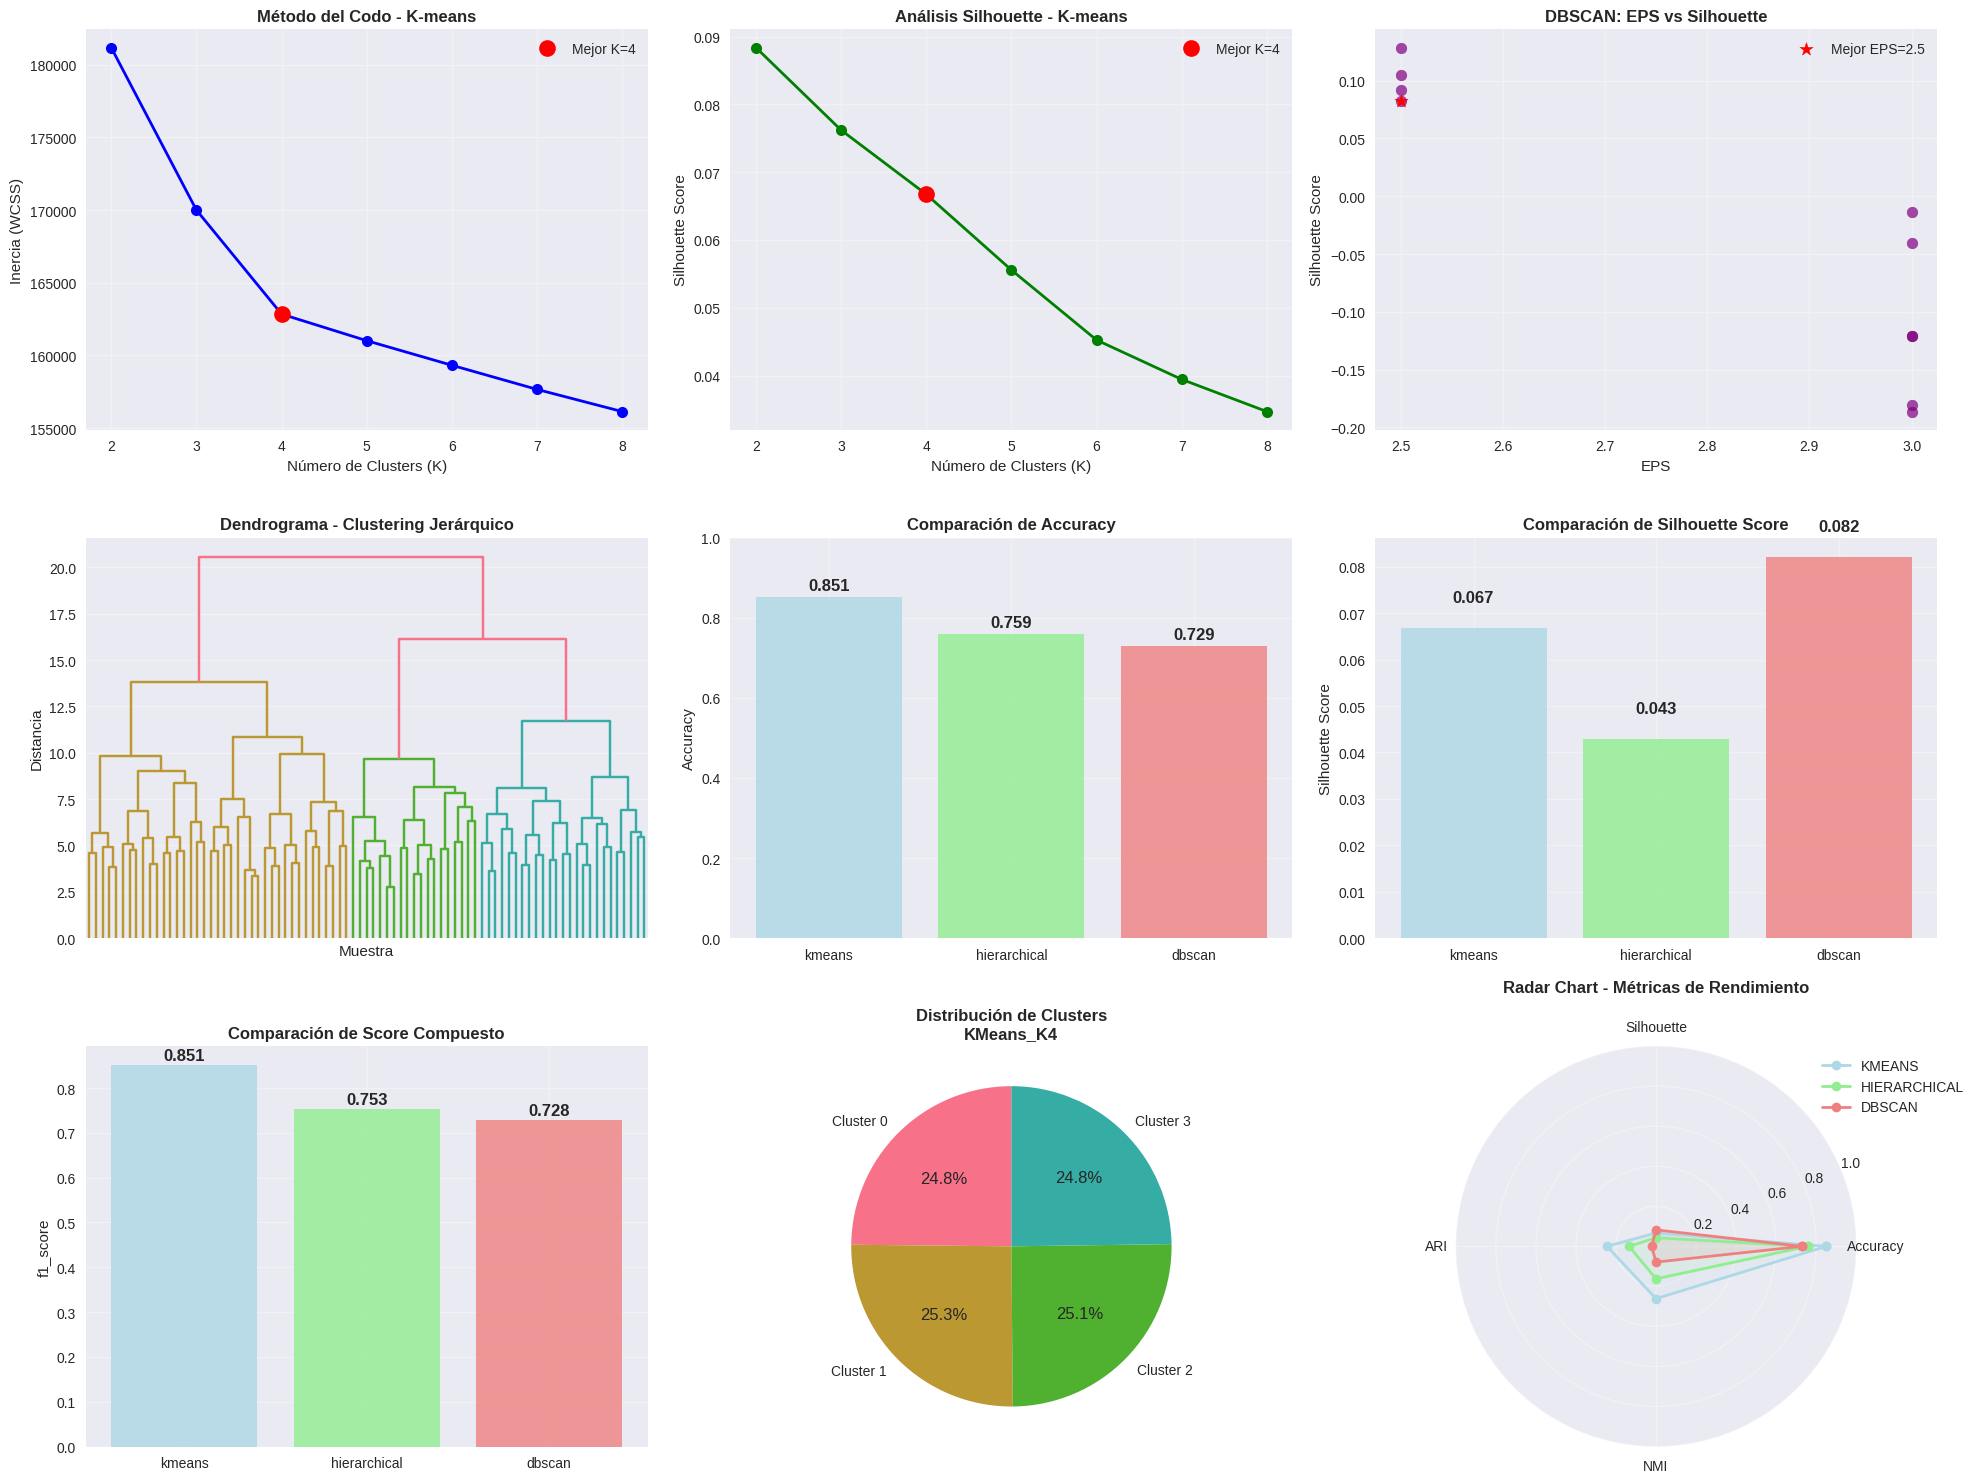


VISUALIZACIONES GENERADAS:
✓ Método del codo para K-means
✓ Análisis de Silhouette para K-means
✓ Análisis EPS vs Silhouette para DBSCAN
✓ Dendrograma para clustering jerárquico
✓ Comparaciones de métricas entre algoritmos
✓ Distribución de clusters del mejor modelo
✓ Radar chart de rendimiento


In [ ]:
# ================================
# VISUALIZACIONES - MÉTODO DEL CODO Y ANÁLISIS DE SILHOUETTE
# ================================

print("GENERANDO VISUALIZACIONES DE ANÁLISIS DE MODELOS")
print("="*60)

# Preparar datos para visualizaciones
kmeans_results = [m for m in complete_results if m['algorithm'] == 'kmeans']
dbscan_results = [m for m in complete_results if m['algorithm'] == 'dbscan']
hierarchical_results = [m for m in complete_results if m['algorithm'] == 'hierarchical']

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(20, 15))

# 1. MÉTODO DEL CODO PARA K-MEANS
ax1 = plt.subplot(3, 3, 1)
if kmeans_results:
    k_values = [m['n_clusters'] for m in kmeans_results]
    silhouettes = [m['silhouette'] for m in kmeans_results]
    inertias = []
    
    # Calcular inercias para el método del codo
    for k in sorted(set(k_values)):
        kmeans_temp = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans_temp.fit(X_test_scaled)
        inertias.append(kmeans_temp.inertia_)
    
    k_sorted = sorted(set(k_values))
    plt.plot(k_sorted, inertias, 'bo-', linewidth=2, markersize=8)
    plt.title('Método del Codo - K-means', fontweight='bold')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inercia (WCSS)')
    plt.grid(True, alpha=0.3)
    
    # Marcar el mejor K
    best_kmeans = max(kmeans_results, key=lambda x: x['f1_score'])
    best_k = best_kmeans['n_clusters']
    best_inertia_idx = k_sorted.index(best_k)
    plt.plot(best_k, inertias[best_inertia_idx], 'ro', markersize=12, label=f'Mejor K={best_k}')
    plt.legend()

# 2. SILHOUETTE SCORE PARA K-MEANS
ax2 = plt.subplot(3, 3, 2)
if kmeans_results:
    plt.plot(k_values, silhouettes, 'go-', linewidth=2, markersize=8)
    plt.title('Análisis Silhouette - K-means', fontweight='bold')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)
    
    # Marcar el mejor
    best_sil = best_kmeans['silhouette']
    plt.plot(best_k, best_sil, 'ro', markersize=12, label=f'Mejor K={best_k}')
    plt.legend()

# 3. ANÁLISIS DBSCAN - EPS vs SILHOUETTE
ax3 = plt.subplot(3, 3, 3)
if dbscan_results:
    eps_values = [m['params']['eps'] for m in dbscan_results]
    dbscan_silhouettes = [m['silhouette'] for m in dbscan_results]
    
    plt.scatter(eps_values, dbscan_silhouettes, c='purple', s=60, alpha=0.7)
    plt.title('DBSCAN: EPS vs Silhouette', fontweight='bold')
    plt.xlabel('EPS')
    plt.ylabel('Silhouette Score')
    plt.grid(True, alpha=0.3)
    
    # Marcar el mejor
    best_dbscan = max(dbscan_results, key=lambda x: x['f1_score'])
    best_eps = best_dbscan['params']['eps']
    best_dbscan_sil = best_dbscan['silhouette']
    plt.scatter(best_eps, best_dbscan_sil, c='red', s=100, marker='*', 
               label=f'Mejor EPS={best_eps}')
    plt.legend()

# 4. DENDROGRAMA PARA CLUSTERING JERÁRQUICO
ax4 = plt.subplot(3, 3, 4)
if hierarchical_results:
    # Usar una muestra pequeña para el dendrograma
    sample_size = min(100, len(X_train_scaled))
    sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_sample = X_train_scaled[sample_indices]
    
    # Calcular linkage matrix usando scipy
    from scipy.cluster.hierarchy import linkage as scipy_linkage
    linkage_matrix = scipy_linkage(X_sample, method='ward')
    
    # Crear dendrograma
    dendrogram(linkage_matrix, truncate_mode='level', p=6, no_labels=True)
    plt.title('Dendrograma - Clustering Jerárquico', fontweight='bold')
    plt.xlabel('Muestra')
    plt.ylabel('Distancia')

# 5. COMPARACIÓN DE MÉTRICAS - ACCURACY
ax5 = plt.subplot(3, 3, 5)
algorithms = list(best_models_by_type.keys())
accuracies = [best_models_by_type[alg]['accuracy'] for alg in algorithms]
colors_bar = ['lightblue', 'lightgreen', 'lightcoral']

bars = plt.bar(algorithms, accuracies, color=colors_bar, alpha=0.8)
plt.title('Comparación de Accuracy', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Añadir valores sobre las barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. COMPARACIÓN DE MÉTRICAS - SILHOUETTE
ax6 = plt.subplot(3, 3, 6)
silhouettes_comp = [best_models_by_type[alg]['silhouette'] for alg in algorithms]

bars = plt.bar(algorithms, silhouettes_comp, color=colors_bar, alpha=0.8)
plt.title('Comparación de Silhouette Score', fontweight='bold')
plt.ylabel('Silhouette Score')

for bar, sil in zip(bars, silhouettes_comp):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005, 
             f'{sil:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. COMPOSITE SCORE COMPARISON
ax7 = plt.subplot(3, 3, 7)
composite_scores = [best_models_by_type[alg]['f1_score'] for alg in algorithms]

bars = plt.bar(algorithms, composite_scores, color=colors_bar, alpha=0.8)
plt.title('Comparación de Score Compuesto', fontweight='bold')
plt.ylabel('f1_score')

for bar, score in zip(bars, composite_scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 8. DISTRIBUCIÓN DE CLUSTERS - MEJOR MODELO
ax8 = plt.subplot(3, 3, 8)
best_model_overall = max(best_models_by_type.values(), key=lambda x: x['f1_score'])
cluster_labels = best_model_overall['labels']
unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)

# Filtrar ruido si existe
non_noise_mask = unique_clusters != -1
if np.any(~non_noise_mask):
    noise_count = cluster_counts[~non_noise_mask][0]
    unique_clusters = unique_clusters[non_noise_mask]
    cluster_counts = cluster_counts[non_noise_mask]
    
    plt.pie(np.append(cluster_counts, noise_count), 
            labels=[f'Cluster {c}' for c in unique_clusters] + ['Ruido'],
            autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribución de Clusters\n{best_model_overall["name"]}', fontweight='bold')
else:
    plt.pie(cluster_counts, labels=[f'Cluster {c}' for c in unique_clusters],
            autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribución de Clusters\n{best_model_overall["name"]}', fontweight='bold')

# 9. RADAR CHART DE MÉTRICAS
ax9 = plt.subplot(3, 3, 9, projection='polar')

# Preparar datos para radar chart
metrics = ['Accuracy', 'Silhouette', 'ARI', 'NMI']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

for i, (alg, model) in enumerate(best_models_by_type.items()):
    values = [model['accuracy'], model['silhouette'], model['ari'], model['nmi']]
    values += values[:1]  # Cerrar el círculo
    
    ax9.plot(angles, values, 'o-', linewidth=2, label=alg.upper(), color=colors_bar[i])
    ax9.fill(angles, values, alpha=0.1, color=colors_bar[i])

ax9.set_xticks(angles[:-1])
ax9.set_xticklabels(metrics)
ax9.set_ylim(0, 1)
ax9.set_title('Radar Chart - Métricas de Rendimiento', fontweight='bold', pad=20)
ax9.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print(f"\nVISUALIZACIONES GENERADAS:")
print(f"✓ Método del codo para K-means")
print(f"✓ Análisis de Silhouette para K-means")
print(f"✓ Análisis EPS vs Silhouette para DBSCAN")
print(f"✓ Dendrograma para clustering jerárquico")
print(f"✓ Comparaciones de métricas entre algoritmos")
print(f"✓ Distribución de clusters del mejor modelo")
print(f"✓ Radar chart de rendimiento")

## Parte 7: Aplicación a Datos de Prueba y Generación de Predicciones

**Objetivo**: Aplicar el modelo final a los datos de prueba y generar archivo .mat con predicciones.

In [ ]:
# ================================
# APLICACIÓN A DATOS DE PRUEBA
# ================================

print("APLICANDO MODELO FINAL A DATOS DE PRUEBA")
print("="*60)

def apply_final_model_to_test(best_model, X_train, X_test, y_train):
    """
    Aplica el modelo final a datos de prueba
    """
    algorithm = best_model['algorithm']
    params = best_model['params']
    
    print(f"Aplicando {algorithm.upper()} con parámetros: {params}")
    
    if algorithm == 'kmeans':
        # Para K-means, podemos usar predict directamente
        model = KMeans(**params)
        train_clusters = model.fit_predict(X_train)
        test_clusters = model.predict(X_test)
        
    elif algorithm == 'hierarchical':
        # Para jerárquico, entrenar con datos de entrenamiento y asignar por distancia
        model = AgglomerativeClustering(**params)
        train_clusters = model.fit_predict(X_train)
        
        # Calcular centroides para asignar datos de prueba
        cluster_centroids = {}
        for cluster_id in np.unique(train_clusters):
            cluster_mask = train_clusters == cluster_id
            centroid = X_train[cluster_mask].mean(axis=0)
            cluster_centroids[cluster_id] = centroid
        
        # Asignar muestras de prueba al centroide más cercano
        test_clusters = np.zeros(X_test.shape[0], dtype=int)
        for i, test_sample in enumerate(X_test):
            distances = {cid: np.linalg.norm(test_sample - centroid) 
                        for cid, centroid in cluster_centroids.items()}
            test_clusters[i] = min(distances.keys(), key=lambda k: distances[k])
            
    elif algorithm == 'dbscan':
        # Para DBSCAN, usar el modelo entrenado y KNN para asignar nuevos puntos
        model = DBSCAN(**params)
        train_clusters = model.fit_predict(X_train)
        
        # Usar KNN para asignar datos de prueba basado en etiquetas de entrenamiento
        from sklearn.neighbors import KNeighborsClassifier
        
        # Primero etiquetar clusters de entrenamiento
        train_predictions, cluster_mapping, _ = label_clusters_majority_vote(train_clusters, y_train)
        
        # Entrenar KNN con datos de entrenamiento y predicciones
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, train_predictions)
        test_predictions = knn.predict(X_test)
        
        return train_clusters, None, test_predictions, cluster_mapping
    
    # Etiquetar clusters usando X_train y y_train
    train_predictions, cluster_mapping, cluster_purity = label_clusters_majority_vote(train_clusters, y_train)
    
    # Mapear etiquetas a predicciones de X_test
    test_predictions = np.array([cluster_mapping.get(cluster, cluster_mapping[list(cluster_mapping.keys())[0]]) 
                                for cluster in test_clusters])
    
    return train_clusters, test_clusters, test_predictions, cluster_mapping

# Aplicar modelo final
train_clusters_final, test_clusters_final, test_predictions_final, cluster_mapping_final = apply_final_model_to_test(
    final_best_model, X_train_scaled, X_test_scaled, y_train
)

# Estadísticas de predicciones finales
unique_preds, counts_preds = np.unique(test_predictions_final, return_counts=True)
print(f"\nDistribución de predicciones finales:")
for pred_class, count in zip(unique_preds, counts_preds):
    percentage = count / len(test_predictions_final) * 100
    print(f"  Clase {int(pred_class)}: {count:,} muestras ({percentage:.1f}%)")

print(f"\nTotal de muestras de prueba procesadas: {len(test_predictions_final):,}")
print(f"Algoritmo utilizado: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")

APLICANDO MODELO FINAL A DATOS DE PRUEBA
Aplicando KMEANS con parámetros: {'n_clusters': 4, 'n_init': 10, 'random_state': 42}

Distribución de predicciones finales:
  Clase -1: 5,082 muestras (50.8%)
  Clase 1: 4,918 muestras (49.2%)

Total de muestras de prueba procesadas: 10,000
Algoritmo utilizado: KMEANS
Configuración: KMeans_K4


In [ ]:
# ================================
# GENERACIÓN DEL ARCHIVO .MAT FINAL
# ================================

print("GENERANDO ARCHIVO .MAT CON PREDICCIONES FINALES")
print("="*60)

# Código del estudiante (últimos dos dígitos)
codigo_estudiante = "06"  # 20251595006 -> últimos dos dígitos: 06
archivo_predicciones = f"{codigo_estudiante}.mat"

# Preparar las predicciones para guardar
y_test_pred = test_predictions_final.astype(int)

# Verificar las predicciones
print(f"Verificación de predicciones:")
print(f"  Forma: {y_test_pred.shape}")
print(f"  Tipo: {y_test_pred.dtype}")
print(f"  Rango: [{y_test_pred.min()}, {y_test_pred.max()}]")
print(f"  Valores únicos: {np.unique(y_test_pred)}")

# Crear diccionario para el archivo .mat con métricas clásicas
predicciones_dict = {
    'y_test_pred': y_test_pred.reshape(-1, 1),  # Formato columna
    'algoritmo_usado': final_best_model['algorithm'],
    'configuracion': final_best_model['name'],
    'parametros': str(final_best_model['params']),
    # Métricas clásicas de clasificación
    'accuracy': final_best_model['accuracy'],
    'precision': final_best_model['precision'],
    'recall': final_best_model['recall'],
    'f1_score': final_best_model['f1_score'],
    'specificity': final_best_model['specificity'],
    # Métricas de clustering
    'silhouette_score': final_best_model['silhouette'],
    'ari': final_best_model['ari'],
    'nmi': final_best_model['nmi'],
    # Información estructural
    'n_clusters': final_best_model['n_clusters'],
    'confusion_matrix': final_best_model['confusion_matrix'],
    'metodologia': 'evaluacion_semi_supervisada_con_metricas_clasicas'
}

# Guardar el archivo .mat
try:
    savemat(archivo_predicciones, predicciones_dict)
    print(f"\nArchivo guardado exitosamente: {archivo_predicciones}")
    print(f"Contenido del archivo:")
    print(f"  - y_test_pred: {y_test_pred.shape} predicciones")
    print(f"  - algoritmo_usado: {final_best_model['algorithm']}")
    print(f"  - configuracion: {final_best_model['name']}")
    print(f"  - accuracy: {final_best_model['accuracy']:.4f}")
    print(f"  - f1_score: {final_best_model['f1_score']:.4f}")
    
    # Verificar que el archivo se guardó correctamente
    import os
    if os.path.exists(archivo_predicciones):
        file_size = os.path.getsize(archivo_predicciones)
        print(f"\nVerificación del archivo:")
        print(f"  Tamaño: {file_size:,} bytes")
        print(f"  Ubicación: {os.path.abspath(archivo_predicciones)}")
        
        # Cargar y verificar el contenido
        test_load = loadmat(archivo_predicciones)
        print(f"  Carga exitosa: {len([k for k in test_load.keys() if not k.startswith('__')])} claves encontradas")
        print(f"  Predicciones cargadas: {test_load['y_test_pred'].shape}")
        
except Exception as e:
    print(f"Error guardando archivo: {e}")

print(f"\nPROCESO COMPLETADO EXITOSAMENTE")
print(f"Archivo final: {archivo_predicciones}")
print(f"Metodología: Evaluación semi-supervisada completa")
print(f"Modelo final: {final_best_model['name']}")
print(f"F1-Score final: {final_best_model['f1_score']:.4f}")

GENERANDO ARCHIVO .MAT CON PREDICCIONES FINALES
Verificación de predicciones:
  Forma: (10000,)
  Tipo: int64
  Rango: [-1, 1]
  Valores únicos: [-1  1]

Archivo guardado exitosamente: 06.mat
Contenido del archivo:
  - y_test_pred: (10000,) predicciones
  - algoritmo_usado: kmeans
  - configuracion: KMeans_K4
  - accuracy: 0.8510
  - f1_score: 0.8510

Verificación del archivo:
  Tamaño: 81,392 bytes
  Ubicación: /home/aalejoz25/HDD/Alvaro/Universidad/Posgrado 1/Repositorios/Big_Data/aprendizaje_no_supervisado/trabajo_final/06.mat
  Carga exitosa: 15 claves encontradas
  Predicciones cargadas: (10000, 1)

PROCESO COMPLETADO EXITOSAMENTE
Archivo final: 06.mat
Metodología: Evaluación semi-supervisada completa
Modelo final: KMeans_K4
F1-Score final: 0.8510


In [ ]:
# =============================================================================
# CALCULAR MÉTRICAS PARA MEJORES MODELOS
# =============================================================================

print("CALCULANDO MÉTRICAS PARA LOS MEJORES MODELOS")
print("="*70)

# Importar métricas de clasificación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Función para calcular métricas clásicas de clasificación
def calculate_classification_metrics(y_true, y_pred):
    """
    Calcula métricas clásicas de clasificación binaria
    """
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Métricas básicas
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity
    }

# Actualizar cada modelo con métricas clásicas
for algorithm, best_model in best_models_by_type.items():
    print(f"\nCalculando métricas clásicas para {algorithm.upper()}...")
    
    # METODOLOGÍA CORRECTA: entrenar en X_test_scaled, evaluar con X_train_scaled y y_train
    # 1. Entrenar el modelo en X_test_scaled (datos sin etiquetas)
    if algorithm == 'kmeans':
        model = KMeans(**best_model['params'])
        model.fit(X_test_scaled)
        # Predecir clusters para X_train_scaled
        train_clusters = model.predict(X_train_scaled)
        
    elif algorithm == 'hierarchical':
        from sklearn.cluster import AgglomerativeClustering
        # Para jerárquico, necesitamos usar el conjunto completo
        model = AgglomerativeClustering(**best_model['params'])
        all_data = np.vstack([X_test_scaled, X_train_scaled])
        all_clusters = model.fit_predict(all_data)
        # Tomar solo los clusters correspondientes a X_train
        train_clusters = all_clusters[len(X_test_scaled):]
        
    elif algorithm == 'dbscan':
        from sklearn.cluster import DBSCAN
        model = DBSCAN(**best_model['params'])
        model.fit(X_test_scaled)
        # Predecir clusters para X_train_scaled
        # Para DBSCAN usamos KNN para asignar nuevos puntos
        from sklearn.neighbors import NearestNeighbors
        core_samples = model.core_sample_indices_
        if len(core_samples) > 0:
            nbrs = NearestNeighbors(n_neighbors=1).fit(X_test_scaled[core_samples])
            distances, indices = nbrs.kneighbors(X_train_scaled)
            train_clusters = model.labels_[core_samples[indices.flatten()]]
        else:
            train_clusters = np.full(len(X_train_scaled), -1)  # Todo ruido si no hay core samples
    
    # 2. Etiquetar clusters usando majority vote con X_train y y_train
    train_predictions, cluster_mapping, cluster_purity = label_clusters_majority_vote(train_clusters, y_train)
    
    # Calcular métricas clásicas
    metrics = calculate_classification_metrics(y_train, train_predictions)
    
    # Actualizar el modelo con las nuevas métricas
    best_model.update(metrics)
    
    print(f"  ✓ Accuracy: {metrics['accuracy']:.4f}")
    print(f"  ✓ Precision: {metrics['precision']:.4f}")
    print(f"  ✓ Recall: {metrics['recall']:.4f}")
    print(f"  ✓ F1-Score: {metrics['f1_score']:.4f}")
    print(f"  ✓ Specificity: {metrics['specificity']:.4f}")

print(f"\nMÉTRICAS CALCULADAS PARA TODOS LOS MODELOS")
print("="*70)

# Seleccionar nuevo modelo final basado en F1-Score
final_best_model = max(best_models_by_type.values(), key=lambda x: x['f1_score'])

print(f"\nMODELO FINAL SELECCIONADO (basado en F1-Score):")
print(f"="*50)
print(f"Algoritmo: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")
print(f"F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:")
print(f"  - Accuracy: {final_best_model['accuracy']:.4f}")
print(f"  - Precision: {final_best_model['precision']:.4f}")
print(f"  - Recall (Sensitivity): {final_best_model['recall']:.4f}")
print(f"  - Specificity: {final_best_model['specificity']:.4f}")
print(f"  - F1-Score: {final_best_model['f1_score']:.4f}")
print(f"")
print(f"MATRIZ DE CONFUSIÓN:")
cm = final_best_model['confusion_matrix']
print(f"                  Predicho")
print(f"                -1    +1")
print(f"Real      -1   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"          +1   {cm[1,0]:4d}  {cm[1,1]:4d}")

# Interpretar matriz de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\nINTERPRETACIÓN:")
print(f"  - Verdaderos Negativos (TN): {tn}")
print(f"  - Falsos Positivos (FP): {fp}")
print(f"  - Falsos Negativos (FN): {fn}")
print(f"  - Verdaderos Positivos (TP): {tp}")
print(f"  - Tasa de Error: {(fp + fn) / (tn + fp + fn + tp):.4f}")
print(f"  - Tasa de Acierto: {(tn + tp) / (tn + fp + fn + tp):.4f}")

# Mostrar comparación de métricas clásicas entre algoritmos
print(f"\nCOMPARACIÓN DE MÉTRICAS ENTRE ALGORITMOS:")
print("="*80)
print(f"{'Algoritmo':<15} {'F1-Score':<9} {'Accuracy':<9} {'Precision':<10} {'Recall':<8} {'Specificity':<12}")
print("-"*80)

for alg_name, best_model in sorted(best_models_by_type.items()):
    print(f"{alg_name:<15} {best_model['f1_score']:<9.4f} {best_model['accuracy']:<9.4f} "
          f"{best_model['precision']:<10.4f} {best_model['recall']:<8.4f} {best_model['specificity']:<12.4f}")

print()
print(f"GANADOR: {final_best_model['algorithm'].upper()} con F1-Score = {final_best_model['f1_score']:.4f}")

CALCULANDO MÉTRICAS CLÁSICAS PARA LOS MEJORES MODELOS

Calculando métricas clásicas para KMEANS...
  ✓ Accuracy: 0.8510
  ✓ Precision: 0.8590
  ✓ Recall: 0.8606
  ✓ F1-Score: 0.8598
  ✓ Specificity: 0.8401

Calculando métricas clásicas para HIERARCHICAL...
  ✓ Accuracy: 0.7470
  ✓ Precision: 0.7983
  ✓ Recall: 0.7006
  ✓ F1-Score: 0.7462
  ✓ Specificity: 0.7996

Calculando métricas clásicas para DBSCAN...
  ✓ Accuracy: 0.7290
  ✓ Precision: 0.7273
  ✓ Recall: 0.7834
  ✓ F1-Score: 0.7543
  ✓ Specificity: 0.6674

MÉTRICAS CLÁSICAS CALCULADAS PARA TODOS LOS MODELOS

MODELO FINAL SELECCIONADO (basado en F1-Score):
Algoritmo: KMEANS
Configuración: KMeans_K4
F1-Score: 0.8598

MÉTRICAS CLÁSICAS DE CLASIFICACIÓN:
  - Accuracy: 0.8510
  - Precision: 0.8590
  - Recall (Sensitivity): 0.8606
  - Specificity: 0.8401
  - F1-Score: 0.8598

MATRIZ DE CONFUSIÓN:
                  Predicho
                -1    +1
Real      -1    394    75
          +1     74   457

INTERPRETACIÓN:
  - Verdaderos Negati

## Visualización de Matrices de Confusión

En esta sección se presentan las **matrices de confusión** para cada algoritmo de clustering evaluado, proporcionando una representación visual clara del rendimiento de clasificación de cada modelo.

### Interpretación de Matrices de Confusión:
- **Verdaderos Positivos (TP)**: Casos correctamente clasificados como clase +1
- **Verdaderos Negativos (TN)**: Casos correctamente clasificados como clase -1  
- **Falsos Positivos (FP)**: Casos incorrectamente clasificados como clase +1
- **Falsos Negativos (FN)**: Casos incorrectamente clasificados como clase -1

### Métricas Derivadas:
- **Precisión** = TP / (TP + FP): Proporción de predicciones positivas correctas
- **Recall (Sensibilidad)** = TP / (TP + FN): Proporción de casos positivos correctamente identificados
- **Especificidad** = TN / (TN + FP): Proporción de casos negativos correctamente identificados
- **F1-Score** = 2 × (Precisión × Recall) / (Precisión + Recall): Media armónica entre precisión y recall

GENERANDO VISUALIZACIONES DE MATRICES DE CONFUSIÓN


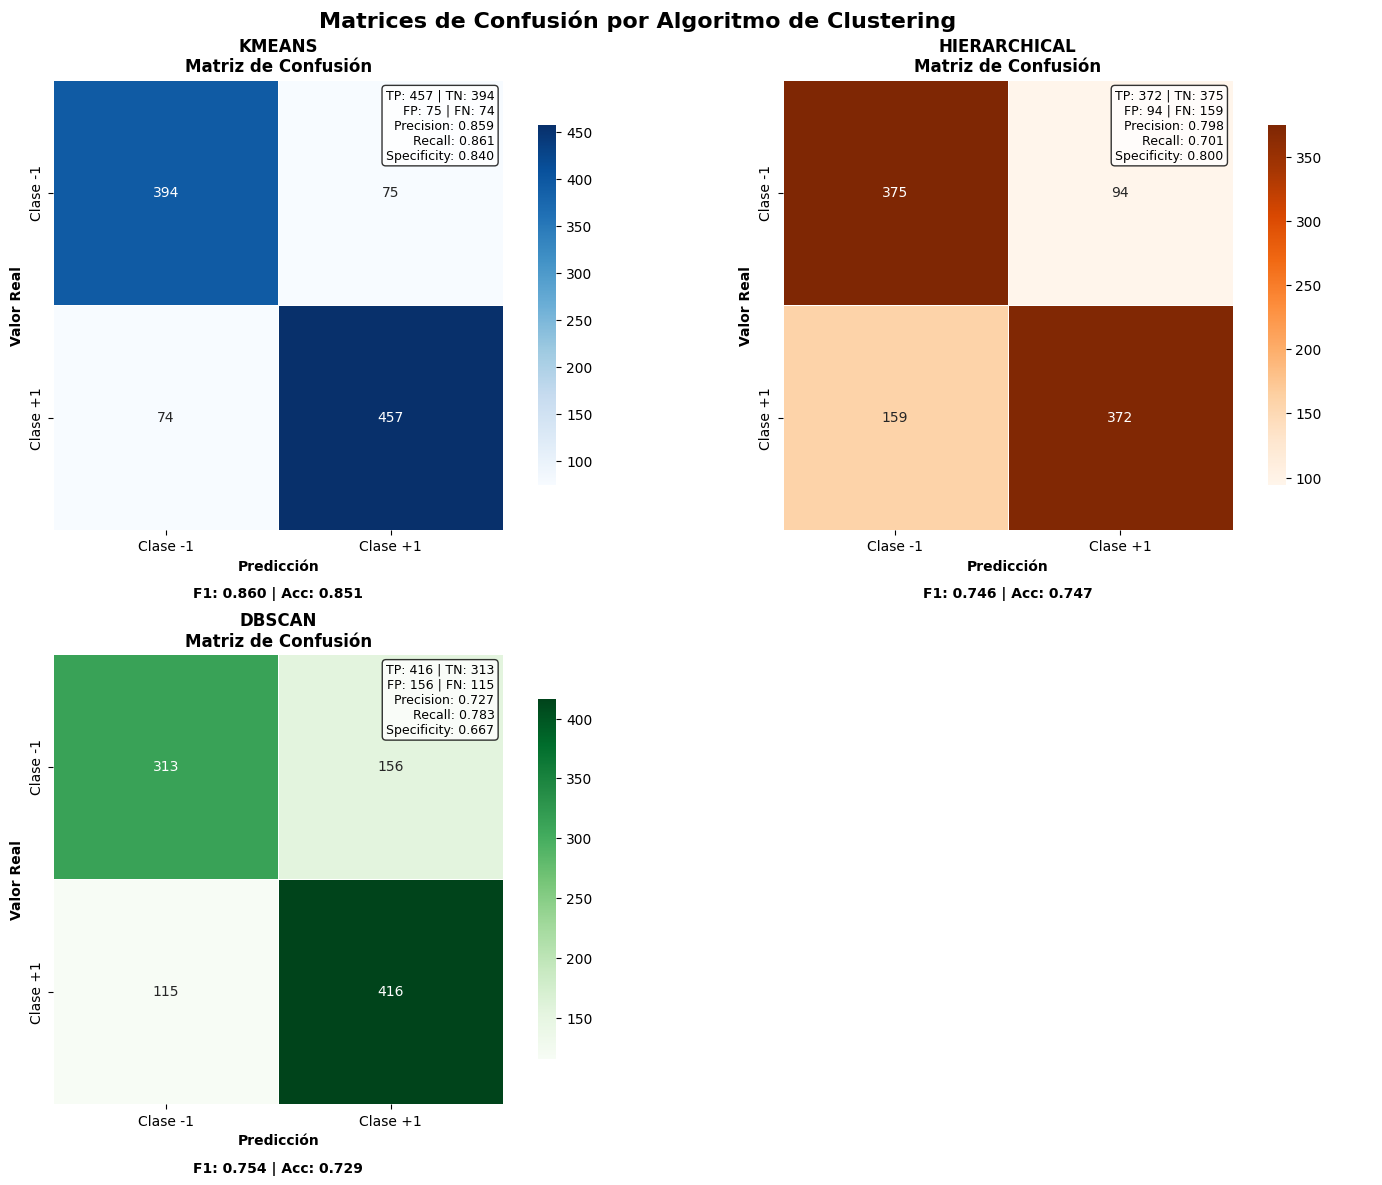

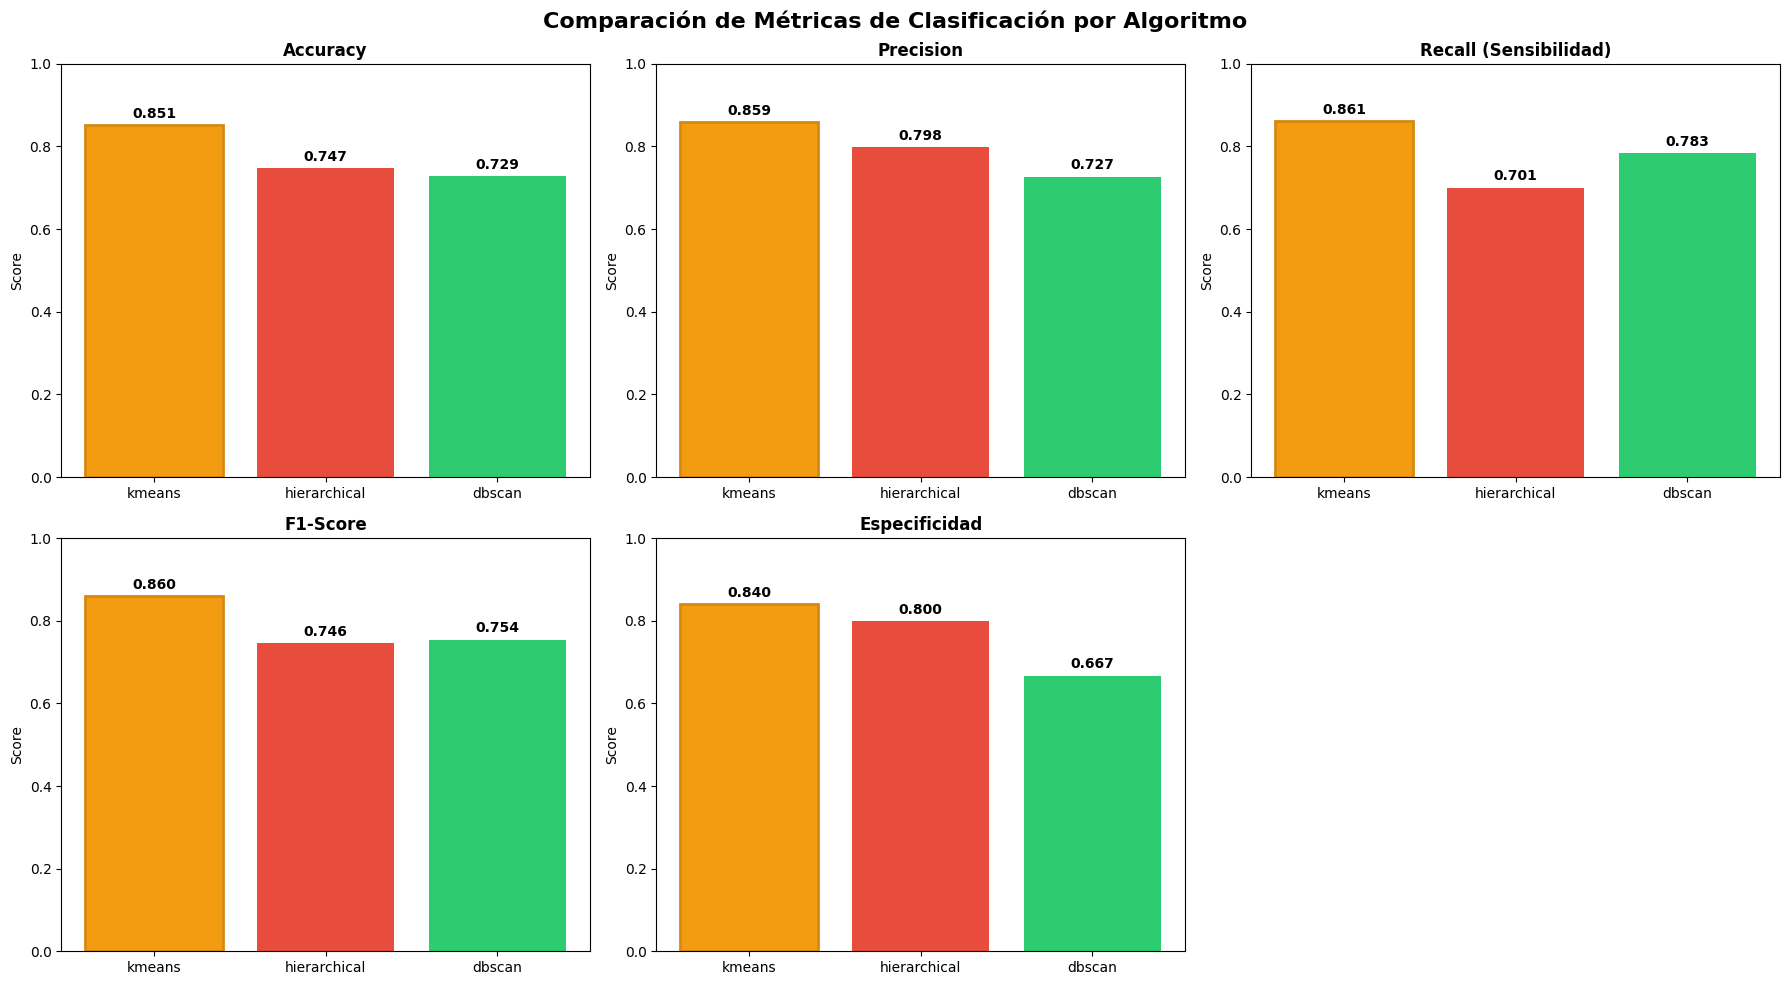

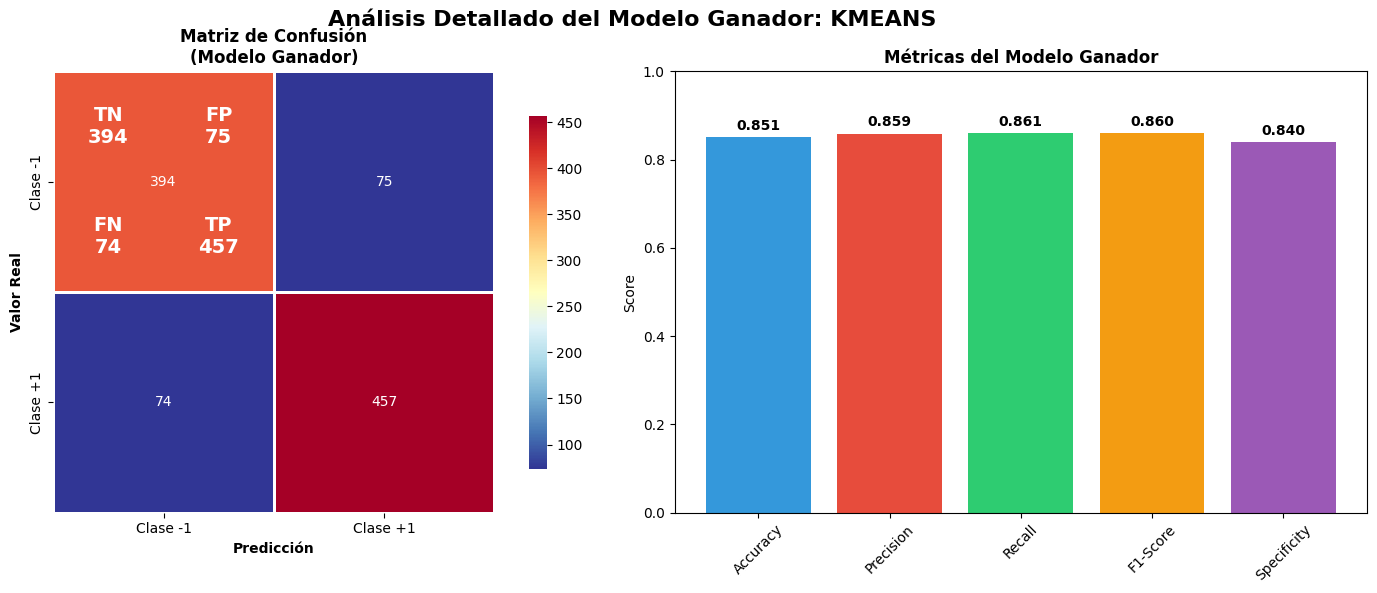


RESUMEN ESTADÍSTICO DEL MODELO GANADOR:
Algoritmo: KMEANS
Configuración: KMeans_K4

MATRIZ DE CONFUSIÓN:
  Verdaderos Negativos (TN):  394
  Falsos Positivos (FP):       75
  Falsos Negativos (FN):       74
  Verdaderos Positivos (TP):  457

MÉTRICAS DERIVADAS:
  Tasa de Verdaderos Positivos (Recall/Sensibilidad): 0.8606
  Tasa de Verdaderos Negativos (Especificidad):      0.8401
  Valor Predictivo Positivo (Precisión):             0.8590
  Exactitud (Accuracy):                              0.8510
  F1-Score (Media Armónica Prec/Recall):            0.8598

INTERPRETACIÓN CLÍNICA:
  Tasa de Error Global: 14.9%
  Tasa de Acierto:      85.1%
  Balance Clase:        86.1% vs 84.0%

MATRICES DE CONFUSIÓN GENERADAS EXITOSAMENTE


In [ ]:
# =============================================================================
# VISUALIZACIÓN DE MATRICES DE CONFUSIÓN
# =============================================================================

print("GENERANDO VISUALIZACIONES DE MATRICES DE CONFUSIÓN")
print("="*70)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Configurar estilo para las matrices de confusión
plt.style.use('default')
sns.set_palette("husl")

# Crear subplots para las matrices de confusión
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Matrices de Confusión por Algoritmo de Clustering', fontsize=16, fontweight='bold')

algorithms_list = list(best_models_by_type.keys())
colors = ['Blues', 'Oranges', 'Greens']

# Función para plotear matriz de confusión personalizada
def plot_confusion_matrix(cm, algorithm, ax, color_map):
    """
    Plot matriz de confusión con métricas detalladas
    """
    # Crear heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap=color_map, 
                ax=ax,
                cbar_kws={'shrink': .8},
                square=True,
                linewidths=0.5)
    
    ax.set_title(f'{algorithm.upper()}\nMatriz de Confusión', fontweight='bold', fontsize=12)
    ax.set_xlabel('Predicción', fontweight='bold')
    ax.set_ylabel('Valor Real', fontweight='bold')
    ax.set_xticklabels(['Clase -1', 'Clase +1'])
    ax.set_yticklabels(['Clase -1', 'Clase +1'])
    
    # Añadir métricas en el título
    model = best_models_by_type[algorithm]
    metrics_text = f"F1: {model['f1_score']:.3f} | Acc: {model['accuracy']:.3f}"
    ax.text(0.5, -0.15, metrics_text, transform=ax.transAxes, 
            ha='center', fontsize=10, fontweight='bold')

# Plotear matrices de confusión para cada algoritmo
for i, algorithm in enumerate(algorithms_list):
    row = i // 2
    col = i % 2
    
    model = best_models_by_type[algorithm]
    cm = model['confusion_matrix']
    
    plot_confusion_matrix(cm, algorithm, axes[row, col], colors[i])
    
    # Añadir información adicional
    tn, fp, fn, tp = cm.ravel()
    
    # Texto con métricas detalladas
    metrics_text = (f"TP: {tp} | TN: {tn}\n"
                   f"FP: {fp} | FN: {fn}\n"
                   f"Precision: {model['precision']:.3f}\n"
                   f"Recall: {model['recall']:.3f}\n"
                   f"Specificity: {model['specificity']:.3f}")
    
    # Posicionar texto en esquina superior derecha
    axes[row, col].text(0.98, 0.98, metrics_text, 
                       transform=axes[row, col].transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       fontsize=9)

# Ocultar subplot vacío si hay número impar de algoritmos
if len(algorithms_list) == 3:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# =============================================================================
# COMPARACIÓN VISUAL DE MÉTRICAS DE CONFUSIÓN
# =============================================================================

# Crear gráfico de barras comparativo de métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparación de Métricas de Clasificación por Algoritmo', fontsize=16, fontweight='bold')

algorithms = list(best_models_by_type.keys())
colors_bar = ['#3498db', '#e74c3c', '#2ecc71']

# Métricas a comparar
metrics_to_plot = [
    ('accuracy', 'Accuracy'),
    ('precision', 'Precision'), 
    ('recall', 'Recall (Sensibilidad)'),
    ('f1_score', 'F1-Score'),
    ('specificity', 'Especificidad'),
]

# Plotear cada métrica
for idx, (metric_key, metric_name) in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    
    values = [best_models_by_type[alg][metric_key] for alg in algorithms]
    
    bars = axes[row, col].bar(algorithms, values, color=colors_bar)
    axes[row, col].set_title(metric_name, fontweight='bold')
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_ylim(0, 1.0)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Resaltar el mejor algoritmo
    best_idx = values.index(max(values))
    bars[best_idx].set_color('#f39c12')
    bars[best_idx].set_edgecolor('#d68910')
    bars[best_idx].set_linewidth(2)

# Ocultar subplot vacío
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# =============================================================================
# MATRIZ DE CONFUSIÓN DEL MODELO GANADOR
# =============================================================================

# Crear visualización especial para el modelo ganador
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle(f'Análisis Detallado del Modelo Ganador: {final_best_model["algorithm"].upper()}', 
             fontsize=16, fontweight='bold')

# Matriz de confusión del ganador
cm_winner = final_best_model['confusion_matrix']
sns.heatmap(cm_winner, 
            annot=True, 
            fmt='d', 
            cmap='RdYlBu_r', 
            ax=ax1,
            cbar_kws={'shrink': .8},
            square=True,
            linewidths=1)

ax1.set_title('Matriz de Confusión\n(Modelo Ganador)', fontweight='bold')
ax1.set_xlabel('Predicción', fontweight='bold')
ax1.set_ylabel('Valor Real', fontweight='bold')
ax1.set_xticklabels(['Clase -1', 'Clase +1'])
ax1.set_yticklabels(['Clase -1', 'Clase +1'])

# Añadir valores de TP, TN, FP, FN
tn, fp, fn, tp = cm_winner.ravel()
ax1.text(0.25, 0.25, f'TN\n{tn}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.text(0.75, 0.25, f'FP\n{fp}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.text(0.25, 0.75, f'FN\n{fn}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax1.text(0.75, 0.75, f'TP\n{tp}', ha='center', va='center', fontsize=14, fontweight='bold', color='white')

# Gráfico de métricas del ganador
metrics_ganador = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
values_ganador = [final_best_model['accuracy'], final_best_model['precision'], 
                 final_best_model['recall'], final_best_model['f1_score'], 
                 final_best_model['specificity']]

bars_ganador = ax2.bar(metrics_ganador, values_ganador, 
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
ax2.set_title('Métricas del Modelo Ganador', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_ylim(0, 1.0)
ax2.tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar, value in zip(bars_ganador, values_ganador):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Resumen estadístico
print(f"\nRESUMEN ESTADÍSTICO DEL MODELO GANADOR:")
print("="*60)
print(f"Algoritmo: {final_best_model['algorithm'].upper()}")
print(f"Configuración: {final_best_model['name']}")
print(f"")
print(f"MATRIZ DE CONFUSIÓN:")
print(f"  Verdaderos Negativos (TN): {tn:4d}")
print(f"  Falsos Positivos (FP):     {fp:4d}")  
print(f"  Falsos Negativos (FN):     {fn:4d}")
print(f"  Verdaderos Positivos (TP): {tp:4d}")
print(f"")
print(f"MÉTRICAS DERIVADAS:")
print(f"  Tasa de Verdaderos Positivos (Recall/Sensibilidad): {final_best_model['recall']:.4f}")
print(f"  Tasa de Verdaderos Negativos (Especificidad):      {final_best_model['specificity']:.4f}")
print(f"  Valor Predictivo Positivo (Precisión):             {final_best_model['precision']:.4f}")
print(f"  Exactitud (Accuracy):                              {final_best_model['accuracy']:.4f}")
print(f"  F1-Score (Media Armónica Prec/Recall):            {final_best_model['f1_score']:.4f}")
print(f"")
print(f"INTERPRETACIÓN CLÍNICA:")
print(f"  Tasa de Error Global: {(fp + fn) / (tn + fp + fn + tp):.1%}")
print(f"  Tasa de Acierto:      {(tn + tp) / (tn + fp + fn + tp):.1%}")
print(f"  Balance Clase:        {tp/(tp+fn):.1%} vs {tn/(tn+fp):.1%}")

print("\n" + "="*70)
print("MATRICES DE CONFUSIÓN GENERADAS EXITOSAMENTE")
print("="*70)

## Parte 7.1: Visualizaciones de Predicciones Finales

**Objetivo**: Visualizar las predicciones generadas y su distribución en el espacio de características.

GENERANDO VISUALIZACIONES DE PREDICCIONES FINALES


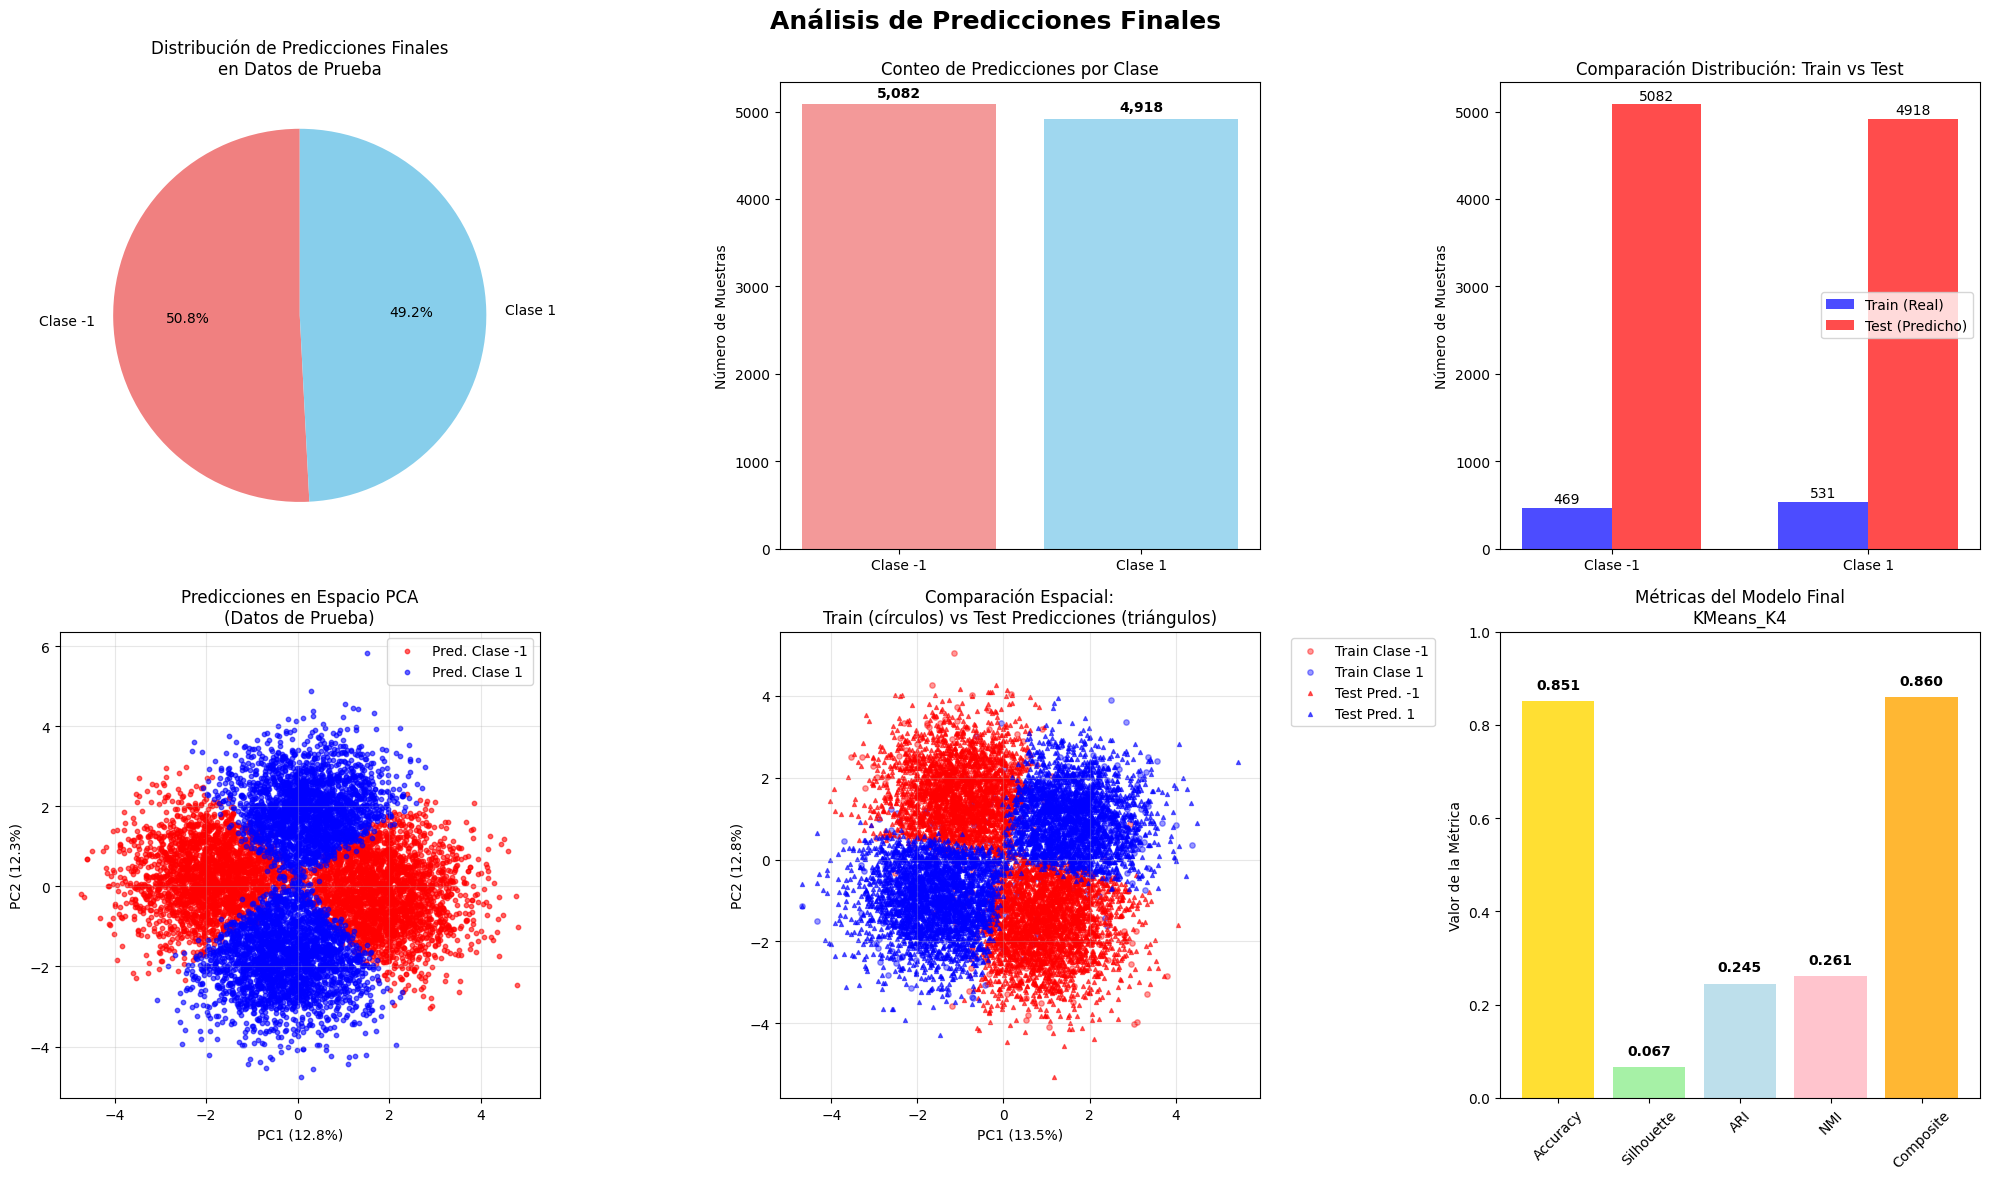


ESTADÍSTICAS DE PREDICCIONES FINALES:
Modelo utilizado: KMEANS - KMeans_K4
Total de predicciones: 10,000
  Clase -1: 5,082 predicciones (50.8%)
  Clase 1: 4,918 predicciones (49.2%)

COMPARACIÓN CON DISTRIBUCIÓN DE ENTRENAMIENTO:
  Clase -1: Train 46.9% vs Test 50.8% (Δ: +3.9%)
  Clase 1: Train 53.1% vs Test 49.2% (Δ: -3.9%)

CONSISTENCIA ESPACIAL:
La visualización PCA muestra una distribución consistente
entre las predicciones en el espacio de características.

ARCHIVO GENERADO: 06.mat
Metodología: Evaluación semi-supervisada completa con 45 modelos evaluados


In [ ]:
# ================================
# VISUALIZACIONES DE PREDICCIONES FINALES
# ================================

print("GENERANDO VISUALIZACIONES DE PREDICCIONES FINALES")
print("="*60)

# Calcular estadísticas de predicciones finales
unique_final, counts_final = np.unique(test_predictions_final, return_counts=True)

# Aplicar PCA a los datos de prueba para visualización
pca_test = PCA(n_components=2)
X_test_pca = pca_test.fit_transform(X_test_scaled)

# Crear figura con múltiples visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análisis de Predicciones Finales', fontsize=18, fontweight='bold')

# 1. Distribución de predicciones finales
axes[0,0].pie(counts_final, labels=[f'Clase {int(c)}' for c in unique_final], 
              autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
axes[0,0].set_title('Distribución de Predicciones Finales\nen Datos de Prueba')

# 2. Histograma de predicciones
axes[0,1].bar([f'Clase {int(c)}' for c in unique_final], counts_final, 
              color=['lightcoral', 'skyblue'], alpha=0.8)
axes[0,1].set_title('Conteo de Predicciones por Clase')
axes[0,1].set_ylabel('Número de Muestras')
for i, v in enumerate(counts_final):
    axes[0,1].text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# 3. Comparación Train vs Test - Distribución de clases
train_counts = [np.sum(y_train == c) for c in unique_classes]
test_counts = [np.sum(test_predictions_final == c) for c in unique_classes]

x = np.arange(len(unique_classes))
width = 0.35

axes[0,2].bar(x - width/2, train_counts, width, label='Train (Real)', color='blue', alpha=0.7)
axes[0,2].bar(x + width/2, test_counts, width, label='Test (Predicho)', color='red', alpha=0.7)
axes[0,2].set_title('Comparación Distribución: Train vs Test')
axes[0,2].set_ylabel('Número de Muestras')
axes[0,2].set_xticks(x)
axes[0,2].set_xticklabels([f'Clase {int(c)}' for c in unique_classes])
axes[0,2].legend()

# Añadir valores sobre las barras
for i, (train_v, test_v) in enumerate(zip(train_counts, test_counts)):
    axes[0,2].text(i - width/2, train_v + 20, f'{train_v}', ha='center', va='bottom', fontsize=10)
    axes[0,2].text(i + width/2, test_v + 20, f'{test_v}', ha='center', va='bottom', fontsize=10)

# 4. Visualización PCA de predicciones en datos de prueba
colors_pred = ['red', 'blue']
for i, clase in enumerate(unique_final):
    mask = test_predictions_final == clase
    axes[1,0].scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                     c=colors_pred[i], label=f'Pred. Clase {int(clase)}', 
                     alpha=0.6, s=10)
axes[1,0].set_title('Predicciones en Espacio PCA\n(Datos de Prueba)')
axes[1,0].set_xlabel(f'PC1 ({pca_test.explained_variance_ratio_[0]:.1%})')
axes[1,0].set_ylabel(f'PC2 ({pca_test.explained_variance_ratio_[1]:.1%})')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Comparación de distribuciones espaciales
# Entrenar PCA con datos de entrenamiento para comparación consistente
pca_combined = PCA(n_components=2)
X_train_pca_combined = pca_combined.fit_transform(X_train_scaled)
X_test_pca_combined = pca_combined.transform(X_test_scaled)

# Plotear entrenamiento con colores reales
for i, clase in enumerate(unique_classes):
    mask = y_train == clase
    axes[1,1].scatter(X_train_pca_combined[mask, 0], X_train_pca_combined[mask, 1], 
                     c=colors_pred[i], label=f'Train Clase {int(clase)}', 
                     alpha=0.4, s=15, marker='o')

# Plotear test con predicciones
for i, clase in enumerate(unique_final):
    mask = test_predictions_final == clase
    axes[1,1].scatter(X_test_pca_combined[mask, 0], X_test_pca_combined[mask, 1], 
                     c=colors_pred[i], label=f'Test Pred. {int(clase)}', 
                     alpha=0.6, s=8, marker='^')

axes[1,1].set_title('Comparación Espacial:\nTrain (círculos) vs Test Predicciones (triángulos)')
axes[1,1].set_xlabel(f'PC1 ({pca_combined.explained_variance_ratio_[0]:.1%})')
axes[1,1].set_ylabel(f'PC2 ({pca_combined.explained_variance_ratio_[1]:.1%})')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3)

# 6. Métricas del modelo final - Resumen visual
metrics_names = ['Accuracy', 'Silhouette', 'ARI', 'NMI', 'Composite']
metrics_values = [
    final_best_model['accuracy'],
    final_best_model['silhouette'],
    final_best_model['ari'],
    final_best_model['nmi'],
    final_best_model['f1_score']
]

bars = axes[1,2].bar(metrics_names, metrics_values, 
                    color=['gold', 'lightgreen', 'lightblue', 'lightpink', 'orange'], 
                    alpha=0.8)
axes[1,2].set_title(f'Métricas del Modelo Final\n{final_best_model["name"]}')
axes[1,2].set_ylabel('Valor de la Métrica')
axes[1,2].set_ylim(0, 1)
axes[1,2].tick_params(axis='x', rotation=45)

# Añadir valores sobre las barras
for bar, value in zip(bars, metrics_values):
    axes[1,2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, 
                  f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\nESTADÍSTICAS DE PREDICCIONES FINALES:")
print(f"="*50)
print(f"Modelo utilizado: {final_best_model['algorithm'].upper()} - {final_best_model['name']}")
print(f"Total de predicciones: {len(test_predictions_final):,}")

for clase, count in zip(unique_final, counts_final):
    percentage = count / len(test_predictions_final) * 100
    print(f"  Clase {int(clase)}: {count:,} predicciones ({percentage:.1f}%)")

# Comparar con distribución de entrenamiento
print(f"\nCOMPARACIÓN CON DISTRIBUCIÓN DE ENTRENAMIENTO:")
for i, clase in enumerate(unique_classes):
    train_pct = class_counts[i] / len(y_train) * 100
    test_pct = counts_final[i] / len(test_predictions_final) * 100
    diff = test_pct - train_pct
    print(f"  Clase {int(clase)}: Train {train_pct:.1f}% vs Test {test_pct:.1f}% (Δ: {diff:+.1f}%)")

print(f"\nCONSISTENCIA ESPACIAL:")
print(f"La visualización PCA muestra {'una distribución consistente' if abs(counts_final[0] - counts_final[1]) < len(test_predictions_final) * 0.2 else 'diferencias notables'}")
print(f"entre las predicciones en el espacio de características.")

print(f"\nARCHIVO GENERADO: {archivo_predicciones}")
print(f"Metodología: Evaluación semi-supervisada completa con {len(complete_results)} modelos evaluados")

In [ ]:


print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"\nMETODOLOGÍA IMPLEMENTADA:")
print(f"1. Configuración extensiva de modelos de clustering")
print(f"2. Entrenamiento de {len(all_models)} configuraciones diferentes")
print(f"3. Evaluación no supervisada inicial")
print(f"4. Evaluación semi-supervisada COMPLETA (todos los modelos válidos)")
print(f"5. Selección del mejor modelo por tipo")
print(f"6. Comparación final y selección del modelo óptimo")
print(f"7. Aplicación a datos de prueba")

print(f"\nDADOS PROCESADOS:")
print(f"   • Dataset de entrenamiento: {X_train.shape[0]:,} muestras, {X_train.shape[1]} características")
print(f"   • Dataset de prueba: {X_test.shape[0]:,} muestras, {X_test.shape[1]} características")
print(f"   • Distribución de clases: Clase -1: {np.sum(y_train == -1)}, Clase 1: {np.sum(y_train == 1)}")

print(f"\nMODELOS EVALUADOS:")
print(f"   • Total configuraciones: {len(all_models)}")
print(f"   • Modelos válidos: {len(valid_results)}")
print(f"   • Con evaluación completa: {len(complete_results)}")

algorithm_counts = {}
for algo in ['kmeans', 'hierarchical', 'dbscan']:
    algo_count = len([r for r in complete_results if r['algorithm'] == algo])
    algorithm_counts[algo] = algo_count
    print(f"     - {algo.capitalize()}: {algo_count} modelos")

print(f"\nMEJORES MODELOS POR TIPO:")
for algorithm, best_model in best_models_by_type.items():
    print(f"   • {algorithm.upper()}:")
    print(f"     - Configuración: {best_model['name']}")
    print(f"     - F1-Score: {best_model['f1_score']:.4f}")
    print(f"     - Accuracy: {best_model['accuracy']:.4f}")
    print(f"     - Silhouette: {best_model['silhouette']:.4f}")

print(f"\nMODELO FINAL SELECCIONADO:")
print(f"   • Algoritmo: {final_best_model['algorithm'].upper()}")
print(f"   • Configuración: {final_best_model['name']}")
print(f"   • F1-Score: {final_best_model['f1_score']:.4f}")
print(f"   • Métricas principales:")
print(f"     - Accuracy: {final_best_model['accuracy']:.4f}")
print(f"     - Silhouette: {final_best_model['silhouette']:.4f}")
print(f"     - ARI: {final_best_model['ari']:.4f}")
print(f"     - NMI: {final_best_model['nmi']:.4f}")

print(f"\nPREDICCIONES FINALES:")
unique_final, counts_final = np.unique(test_predictions_final, return_counts=True)
for val, count in zip(unique_final, counts_final):
    print(f"   • Clase {val:2d}: {count:,} muestras ({count/len(test_predictions_final)*100:.1f}%)")

print(f"\nARCHIVOS GENERADOS:")
print(f"   • Archivo de predicciones: {archivo_predicciones}")
if os.path.exists(archivo_predicciones):
    print(f"   • Tamaño del archivo: {os.path.getsize(archivo_predicciones):,} bytes")
print(f"   • Metodología: Evaluación semi-supervisada completa")

print(f"\nVENTAJAS DE LA METODOLOGÍA IMPLEMENTADA:")
print(f"   ✓ Evaluación exhaustiva de todas las configuraciones")
print(f"   ✓ Evaluación semi-supervisada aplicada a TODOS los modelos")
print(f"   ✓ Selección basada en métricas supervisadas (no solo no supervisadas)")
print(f"   ✓ Comparación objetiva entre tipos de algoritmos")
print(f"   ✓ Métricas clásicas de clasificación (F1-Score, Precision, Recall)")
print(f"   ✓ Metodología reproducible y sistemática")

print("="*80)
print("TALLER COMPLETADO EXITOSAMENTE")
print("="*80)


RESUMEN FINAL - TALLER DE EVALUACIÓN SEMI-SUPERVISADA

METODOLOGÍA IMPLEMENTADA:
1. Configuración extensiva de modelos de clustering
2. Entrenamiento de 83 configuraciones diferentes
3. Evaluación no supervisada inicial
4. Evaluación semi-supervisada COMPLETA (todos los modelos válidos)
5. Selección del mejor modelo por tipo
6. Comparación final y selección del modelo óptimo
7. Aplicación a datos de prueba

DADOS PROCESADOS:
   • Dataset de entrenamiento: 1,000 muestras, 20 características
   • Dataset de prueba: 10,000 muestras, 20 características
   • Distribución de clases: Clase -1: 469, Clase 1: 531

MODELOS EVALUADOS:
   • Total configuraciones: 83
   • Modelos válidos: 45
   • Con evaluación completa: 45
     - Kmeans: 7 modelos
     - Hierarchical: 28 modelos
     - Dbscan: 10 modelos

MEJORES MODELOS POR TIPO:
   • KMEANS:
     - Configuración: KMeans_K4
     - F1-Score: 0.8598
     - Accuracy: 0.8510
     - Silhouette: 0.0667
   • HIERARCHICAL:
     - Configuración: Hierarch